# **Introduction**

<div style = "text-align: justify;">

This project aims to build a machine learning–driven **lead evaluation** system for Swan Chemical Ltd., a leading adhesive manufacturer. The evaluator is prepared as a **MVP** (Minimum Viable Product) to classify incoming company inquiries into actionable lead buckets (Hot, Warm, Cold, Save For Later, Reject) and generate a probability-based lead score to support sales prioritization. The project encompasses data preprocessing, exploratory data analysis, model training and evaluation, hyperparameter tuning, and final model selection. The ultimate goal is to provide Swan Chemical Ltd. with a robust tool that enhances their lead management process and drives business growth.

The dataset used in this project is a synthetic dataset created to mimic real-world lead evaluation scenarios. It contains various features related to company inquiries, such as company size, industry, inquiry source, and historical interaction data. The target variable is the **lead bucket** classification which indicates the potential value of each lead and **lead score**, which assigns a score based on the predicted probabilities of the lead belonging to each bucket.

## Aims & Objectives

<div style="text-align: justify;">

### **Aim**
To build a practical, business-ready machine learning system that helps Swan Chemical Ltd. **identify and prioritize high-potential adhesive customers** by predicting each incoming company lead’s **lead bucket** (Hot/Warm/Cold/Save For Later/Reject) and producing a probability-based **lead score** to guide sales follow-up decisions.

### **Broad Objective**
To develop a machine learning–driven **lead evaluation system** that classifies incoming company inquiries into actionable lead buckets (Hot, Warm, Cold, Save For Later, Reject) and generates a probability-based lead score to support **sales prioritization** for Swan Chemical Ltd.’s adhesive business.

### **Specific Objectives**
1. To design and assemble a structured lead dataset containing operational, commercial, and credibility-related attributes (e.g., location, urgency, expected demand volume, purchase stage, and trust signals) suitable for supervised multi-class modeling.
2. To clean and standardize the dataset by handling inconsistent categories, encoding ordinal variables (e.g., employee size, credibility level, purchase stage), and applying one-hot encoding for nominal fields while preventing preprocessing leakage between train and test splits.
3. To evaluate and compare multiple multi-class classification algorithms (e.g., Multinomial Logistic Regression, Random Forest, LightGBM, HistGradientBoosting, CatBoost) using metrics appropriate for multi-class decisions—especially **Macro F1**, cross-validation stability, and ROC-AUC (OVR and Qualified-vs-Not).
4. To select and tune the strongest model (CatBoost) using hyperparameter optimization to improve generalization and reduce overfitting, ensuring the model performs reliably on unseen lead profiles rather than memorizing training patterns.
5. To produce interpretable model outputs for business usage by converting predicted probabilities into a **QualifiedScore lead score** (P(Hot) + P(Warm)) and mapping that score into simple operational actions (prioritize, nurture, deprioritize) for practical sales workflows.
6. To operationalize deployment by saving fitted artifacts (model, encoders, scaler, metadata) and building a lightweight scoring script that can score new companies without exposing training code, enabling repeatable testing and business-facing use.

</div>

## Setting up the Environment & Importing the Dataset

In [1]:
# import the necessary libraries for data analysis & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# setting seaborn style
sns.set_palette("muted")

In [2]:
# importing the dataset and displaying the first few rows
swan = pd.read_csv(filepath_or_buffer = "datasets/leads_train.csv")
swan.head()

,company_name,industry_category,sub_industry,location_area,district,zone_type,distance_km,company_type,employee_estimate,materials_used,...,order_frequency,urgency_days,payment_terms_expected,has_google_listing,google_review_count,has_phone,credibility_level,lead_source,lead_bucket,lead_score
0,Company_0001,Footwear,Shoe Upper Factory,Tongi,Gazipur,Industrial Zone,23.8,Manufacturer,Medium (50-249),Leather,...,Weekly,25,Credit,Yes,9,Yes,Medium,Walk-in,Cold,47
1,Company_0002,Footwear,Footwear Accessories Supplier,Tejgaon,Dhaka,Industrial Zone,8.3,Retailer,Micro (1-9),Leather,...,One-time,36,Unknown,Yes,18,Yes,Medium,Facebook Page,Cold,38
2,Company_0003,Packaging,Plastic Packaging Manufacturer,Motijheel,Dhaka,Central Dhaka,2.0,Manufacturer,Medium (50-249),Mixed/Unknown,...,Monthly,16,Unknown,Yes,165,Yes,High,Referral,Warm,78
3,Company_0004,Construction,PVC Sheet Workshop,Savar,Dhaka,Industrial Zone,34.9,Manufacturer,Small (10-49),Wood,...,Monthly,25,Cash,Yes,53,Yes,High,Facebook Page,Warm,77
4,Company_0005,Packaging,Label Printing Unit,Gazipur,Gazipur,Industrial Zone,36.0,Trader,Micro (1-9),Mixed/Unknown,...,One-time,31,Cash,Yes,23,Yes,Medium,Distributor Referral,Cold,39


In [3]:
# making a copy of the dataset and working on that
df = swan.copy()

In [4]:
# converting two columns into boolean
yn_map = {"Yes": 1, "No": 0, True: 1, False: 0}
df["has_google_listing"] = df["has_google_listing"].map(yn_map).astype(int)
df["has_phone"] = df["has_phone"].map(yn_map).astype(int)

In [5]:
# checking the shape of the dataset
print("Dataset Shape:", df.shape)

Dataset Shape: (3000, 25)


In [6]:
# taking a look at the data types
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   company_name                    3000 non-null   str    
 1   industry_category               3000 non-null   str    
 2   sub_industry                    3000 non-null   str    
 3   location_area                   3000 non-null   str    
 4   district                        3000 non-null   str    
 5   zone_type                       3000 non-null   str    
 6   distance_km                     3000 non-null   float64
 7   company_type                    3000 non-null   str    
 8   employee_estimate               3000 non-null   str    
 9   materials_used                  3000 non-null   str    
 10  adhesive_type_needed            3000 non-null   str    
 11  product_needed                  3000 non-null   str    
 12  application_type                3000 non-null

## Fixing the Order of some Columns

In [7]:
# the "employee_estimate" column
rating_order = ["Micro (1-9)", "Small (10-49)", "Medium (50-249)", "Large (250+)"]
df["employee_estimate"] = pd.Categorical(
    values = df["employee_estimate"],
    categories = rating_order,
    ordered = True
)

# the "credibility_level" column
rating_order = ["Low", "Medium", "High"]
df["credibility_level"] = pd.Categorical(
    values = df["credibility_level"],
    categories = rating_order,
    ordered = True
)

# the "purchase_stage" column
rating_order = ["Trial Order", "Regular Reorder", "Annual Contract"]
df["purchase_stage"] = pd.Categorical(
    values = df["purchase_stage"],
    categories = rating_order,
    ordered = True
)

# **Exploratory Data Analysis (EDA)**

<div style="text-align: justify;">

Though EDA is not the main focus of this project, we performed some basic EDA to portray the distribution of key features and the target variable, as well as to identify any glaring data quality issues. This helped us understand the dataset better and informed our preprocessing and modeling decisions.

</div>

## Target & Scoring

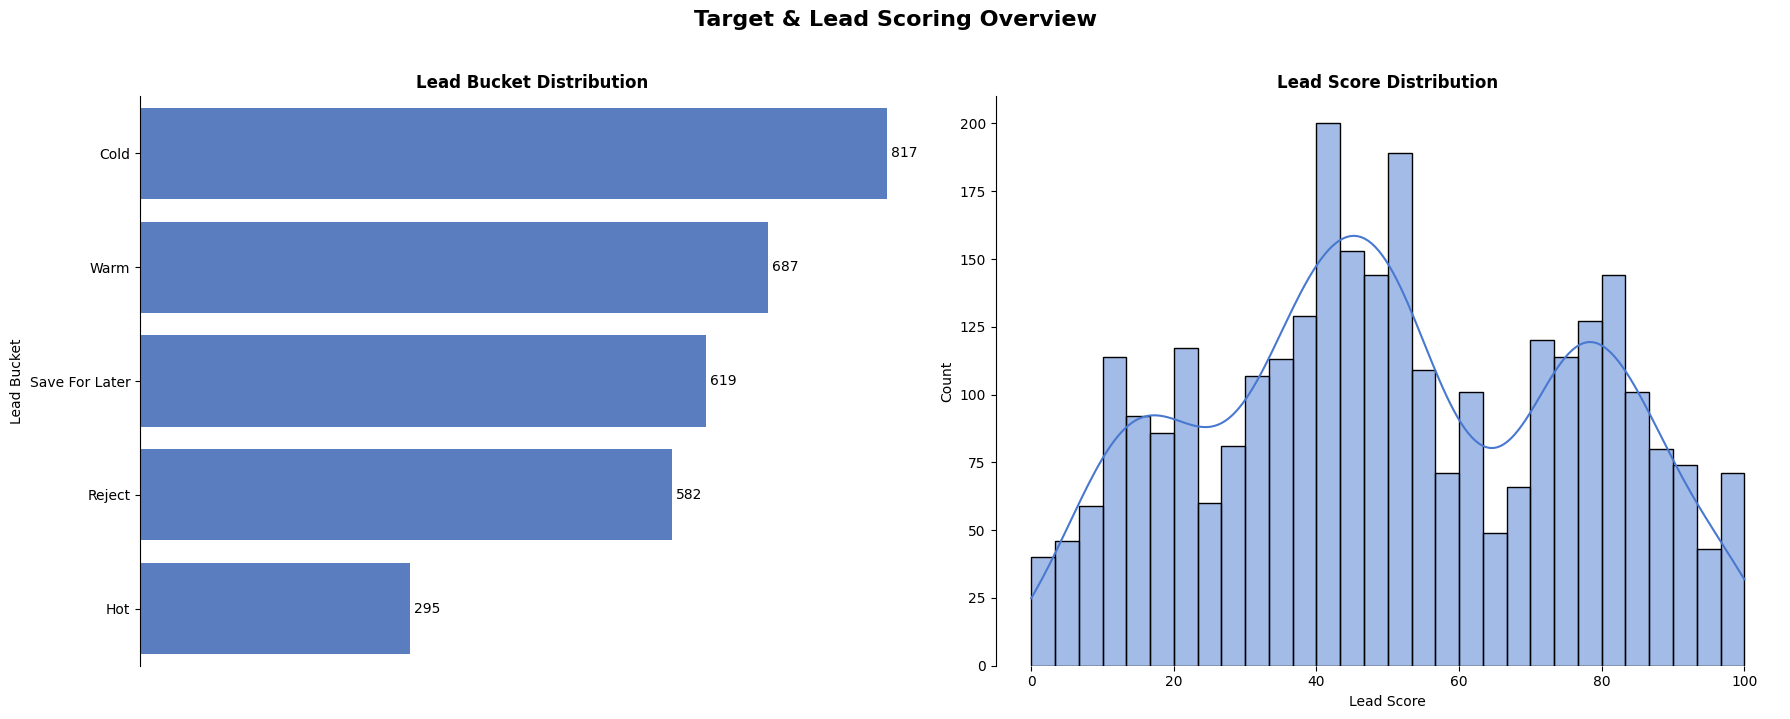

In [8]:
# setting up the plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 7))
fig.suptitle("Target & Lead Scoring Overview", fontsize = 16, fontweight = "bold", y = 1.02)


# plot 01: distribution of the target variable "lead_bucket"
sns.countplot(
    data = df,
    y = "lead_bucket",
    order = df["lead_bucket"].value_counts().index,
    ax = axes[0]
)

axes[0].set_title("Lead Bucket Distribution", fontsize = 12, fontweight = "bold")
axes[0].set_ylabel("Lead Bucket")


# plot 02: distribution of "lead_score"
sns.histplot(
    data = df,
    x = "lead_score",
    bins = 30,
    kde = True,
    ax = axes[1]
)

axes[1].set_title("Lead Score Distribution", fontsize = 12, fontweight = "bold")
axes[1].set_xlabel("Lead Score")
axes[1].set_ylabel("Count")


# adding value labels to each bar
for ax in [axes[0]]:
    for container in ax.containers:
        ax.bar_label(container = container, label_type = "edge", fontsize = 10, padding = 3)


# customizing the plot aesthetics
axes[0].xaxis.set_visible(False)
sns.despine(bottom = True)
plt.tight_layout()
plt.show()

## Geography & Feasibility

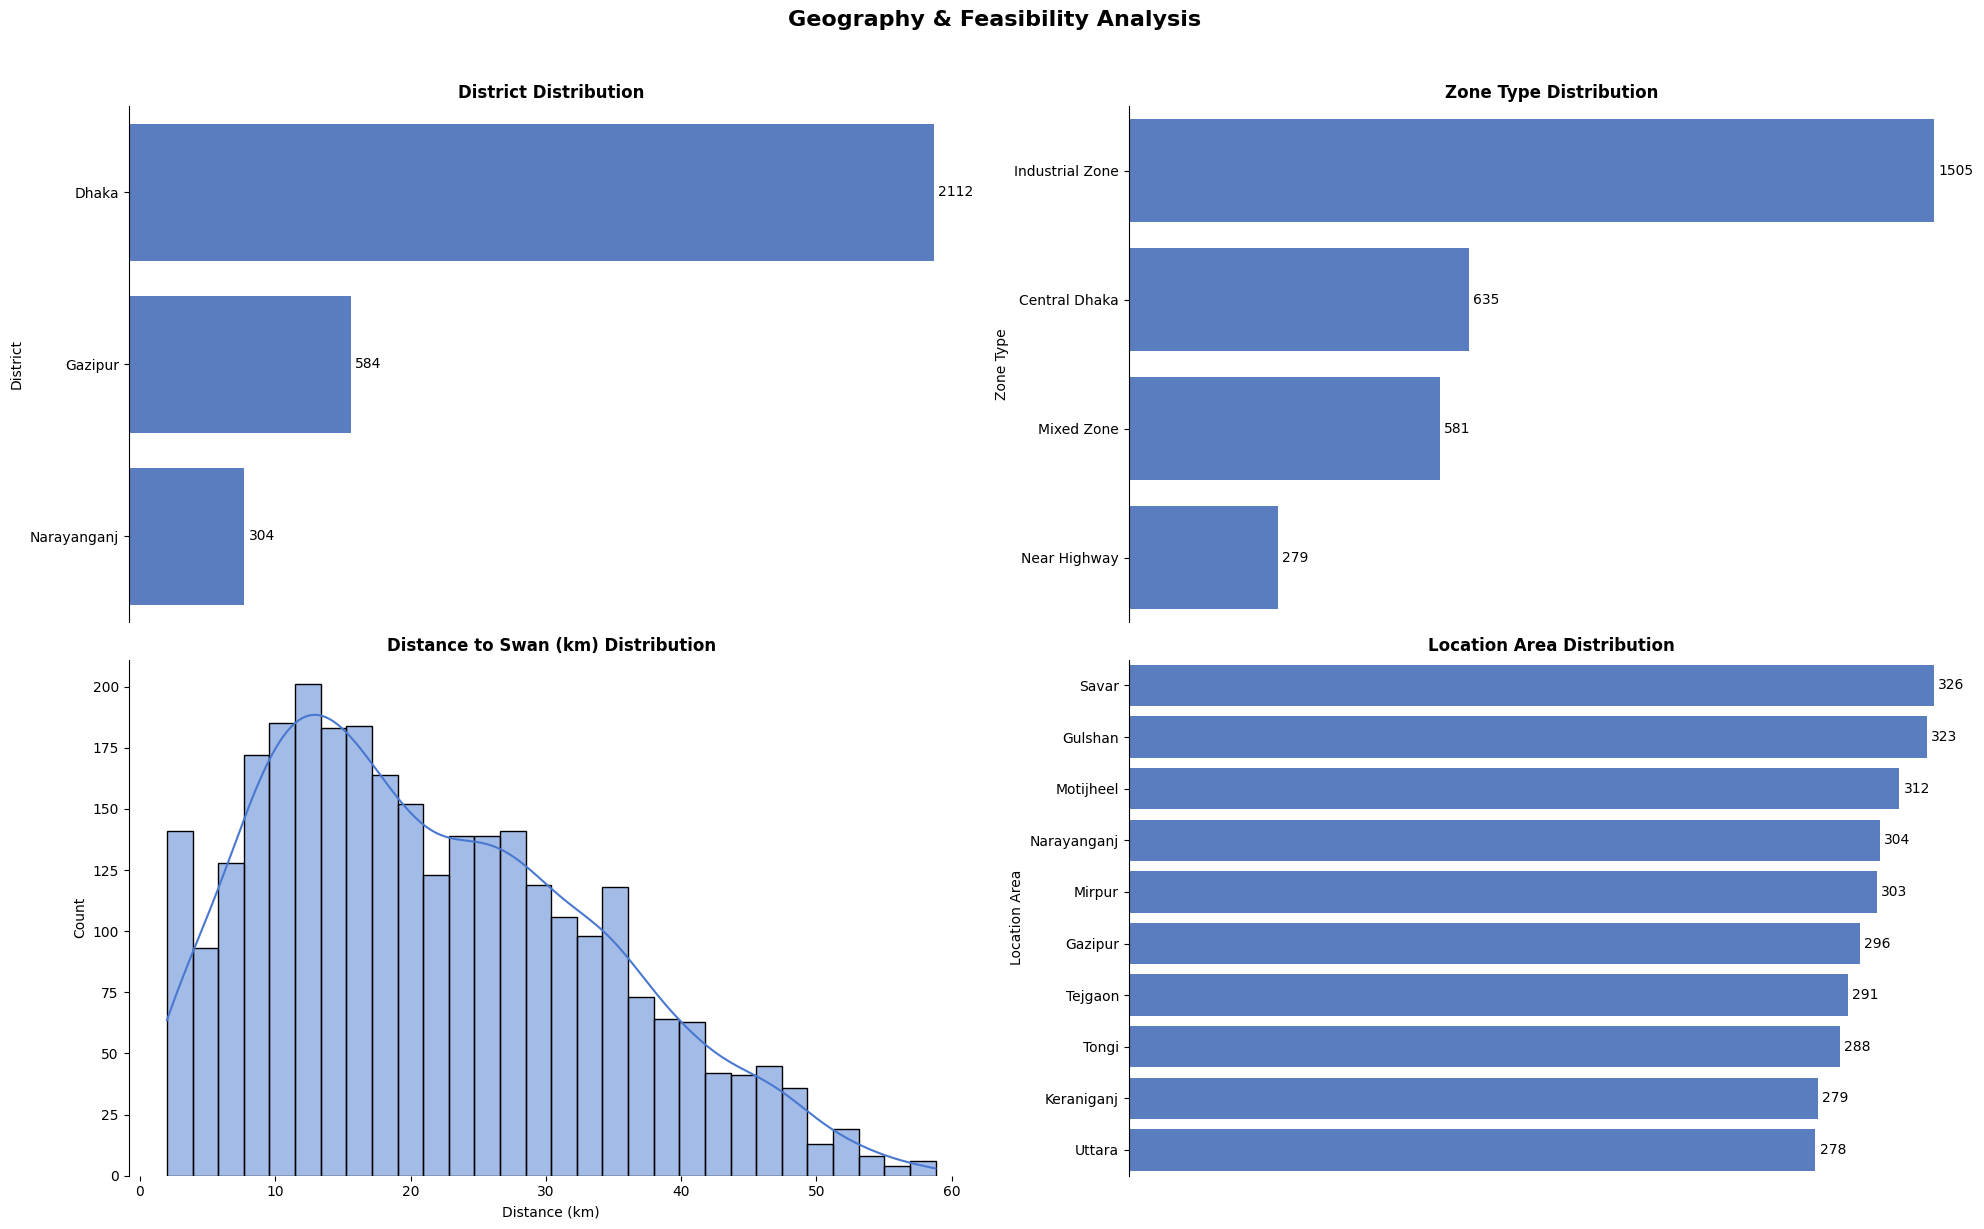

In [9]:
# setting up the plot
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))
fig.suptitle("Geography & Feasibility Analysis", fontsize = 16, fontweight = "bold", y = 1.02)


# plot 01: top 10 "district"
sns.countplot(
    data = df,
    y = "district",
    order = df["district"].value_counts().nlargest(10).index,
    ax = axes[0, 0]
)

axes[0, 0].set_title("District Distribution", fontsize = 12, fontweight = "bold")
axes[0, 0].set_ylabel("District")


# plot 02: distribution of "zone_type"
sns.countplot(
    data = df,
    y = "zone_type",
    order = df["zone_type"].value_counts().index,
    ax = axes[0, 1]
)

axes[0, 1].set_title("Zone Type Distribution", fontsize = 12, fontweight = "bold")
axes[0, 1].set_ylabel("Zone Type")


# plot 03: distribution of "distance_km"
sns.histplot(
    data = df,
    x = "distance_km",
    bins = 30,
    kde = True,
    ax = axes[1, 0]
)

axes[1, 0].set_title("Distance to Swan (km) Distribution", fontsize = 12, fontweight = "bold")
axes[1, 0].set_xlabel("Distance (km)")
axes[1, 0].set_ylabel("Count")


# plot 04: top 10 "location_area"
sns.countplot(
    data = df,
    y = "location_area",
    order = df["location_area"].value_counts().index,
    ax = axes[1, 1]
)

axes[1, 1].set_title("Location Area Distribution", fontsize = 12, fontweight = "bold")
axes[1, 1].set_ylabel("Location Area")


# adding value labels to each bar
for ax in [axes[0, 0], axes[0, 1], axes[1, 1]]:
    for container in ax.containers:
        ax.bar_label(container = container, label_type = "edge", fontsize = 10, padding = 3)


# customizing the plot aesthetics
for ax in [axes[0, 0], axes[0, 1], axes[1, 1]]:
    ax.xaxis.set_visible(False)
sns.despine(bottom = True)
plt.tight_layout()
plt.show()

## Busineess Identity

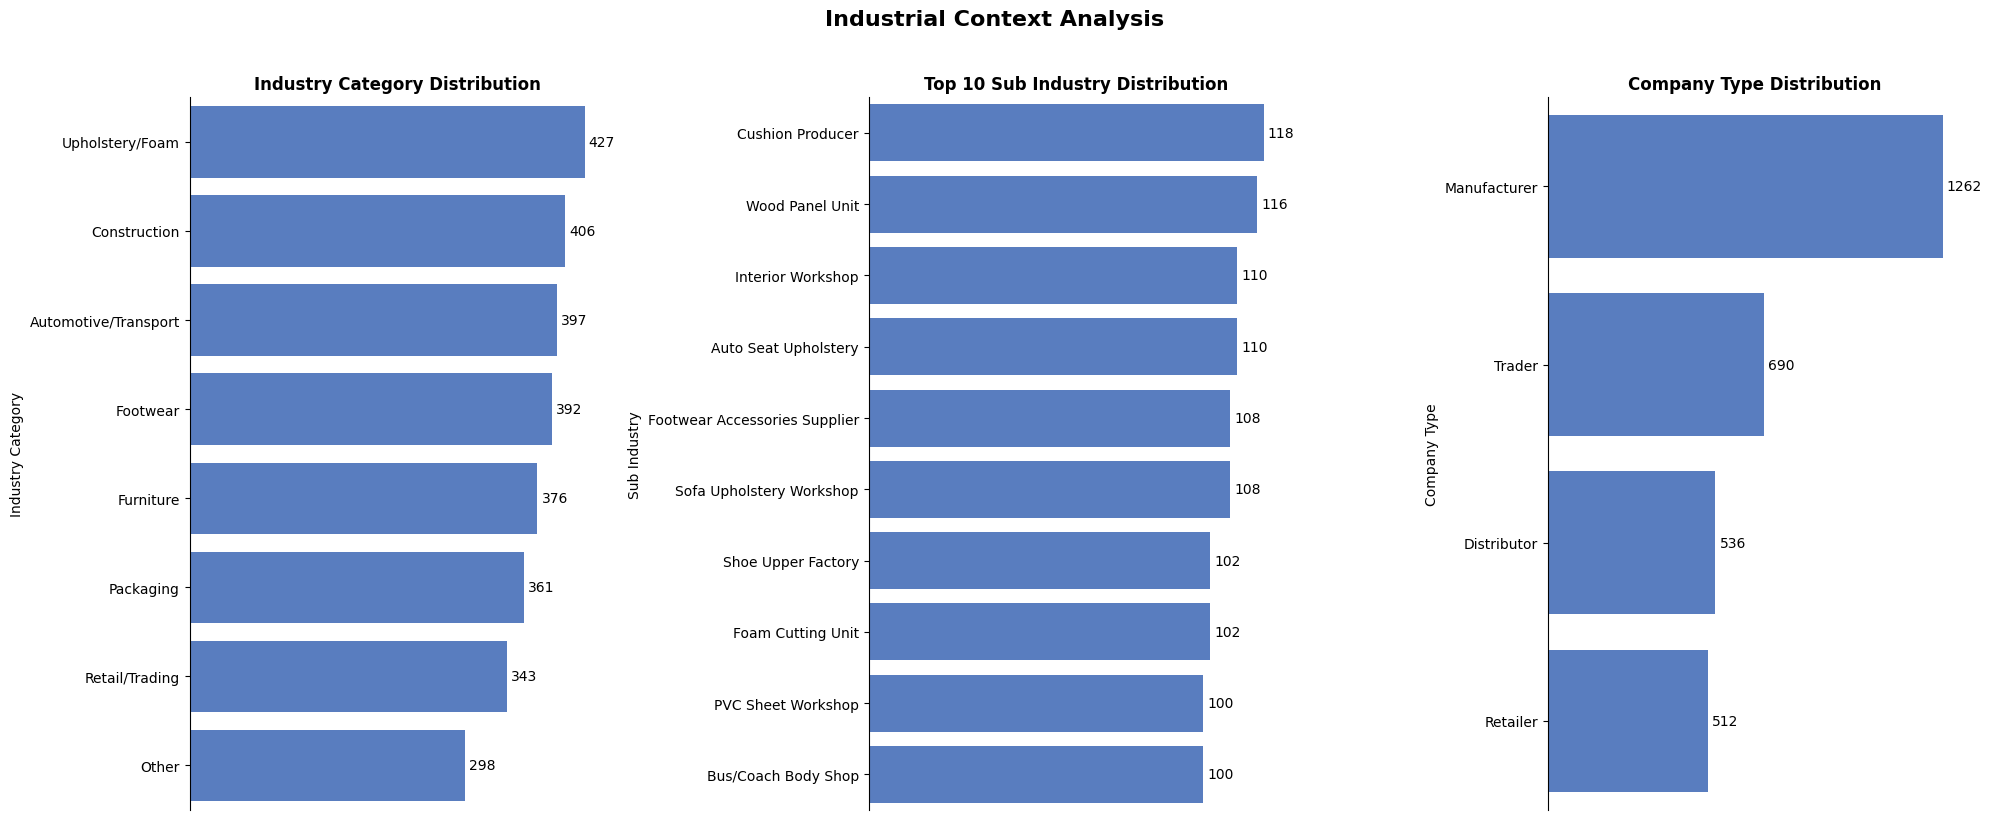

In [10]:
# setting up the plot
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 8))
fig.suptitle("Industrial Context Analysis", fontsize = 16, fontweight = "bold", y = 1.02)


# plot 01: visualizing the distribution of the target variable "industry_category"
sns.countplot(
    data = df,
    y = "industry_category",
    order = df["industry_category"].value_counts().index,
    ax = axes[0]
)

axes[0].set_title("Industry Category Distribution", fontsize = 12, fontweight = "bold")
axes[0].set_ylabel("Industry Category")


# plot 02: visualizing the top ten "sub_industry"
sns.countplot(
    data = df,
    y = "sub_industry",
    order = df["sub_industry"].value_counts().nlargest(10).index,
    ax = axes[1]
)

axes[1].set_title("Top 10 Sub Industry Distribution", fontsize = 12, fontweight = "bold")
axes[1].set_ylabel("Sub Industry")


# plot 03: visualizing the distribution of "company_type"
sns.countplot(
    data = df,
    y = "company_type",
    order = df["company_type"].value_counts().index,
    ax = axes[2]
)

axes[2].set_title("Company Type Distribution", fontsize = 12, fontweight = "bold")
axes[2].set_ylabel("Company Type")


# adding value labels to each bar
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container = container, label_type = "edge", fontsize = 10, padding = 3)


# customizing the plot aesthetics
for ax in axes:
    ax.xaxis.set_visible(False)
sns.despine(bottom = True)
plt.tight_layout()
plt.show()

## Capacity & Credibility

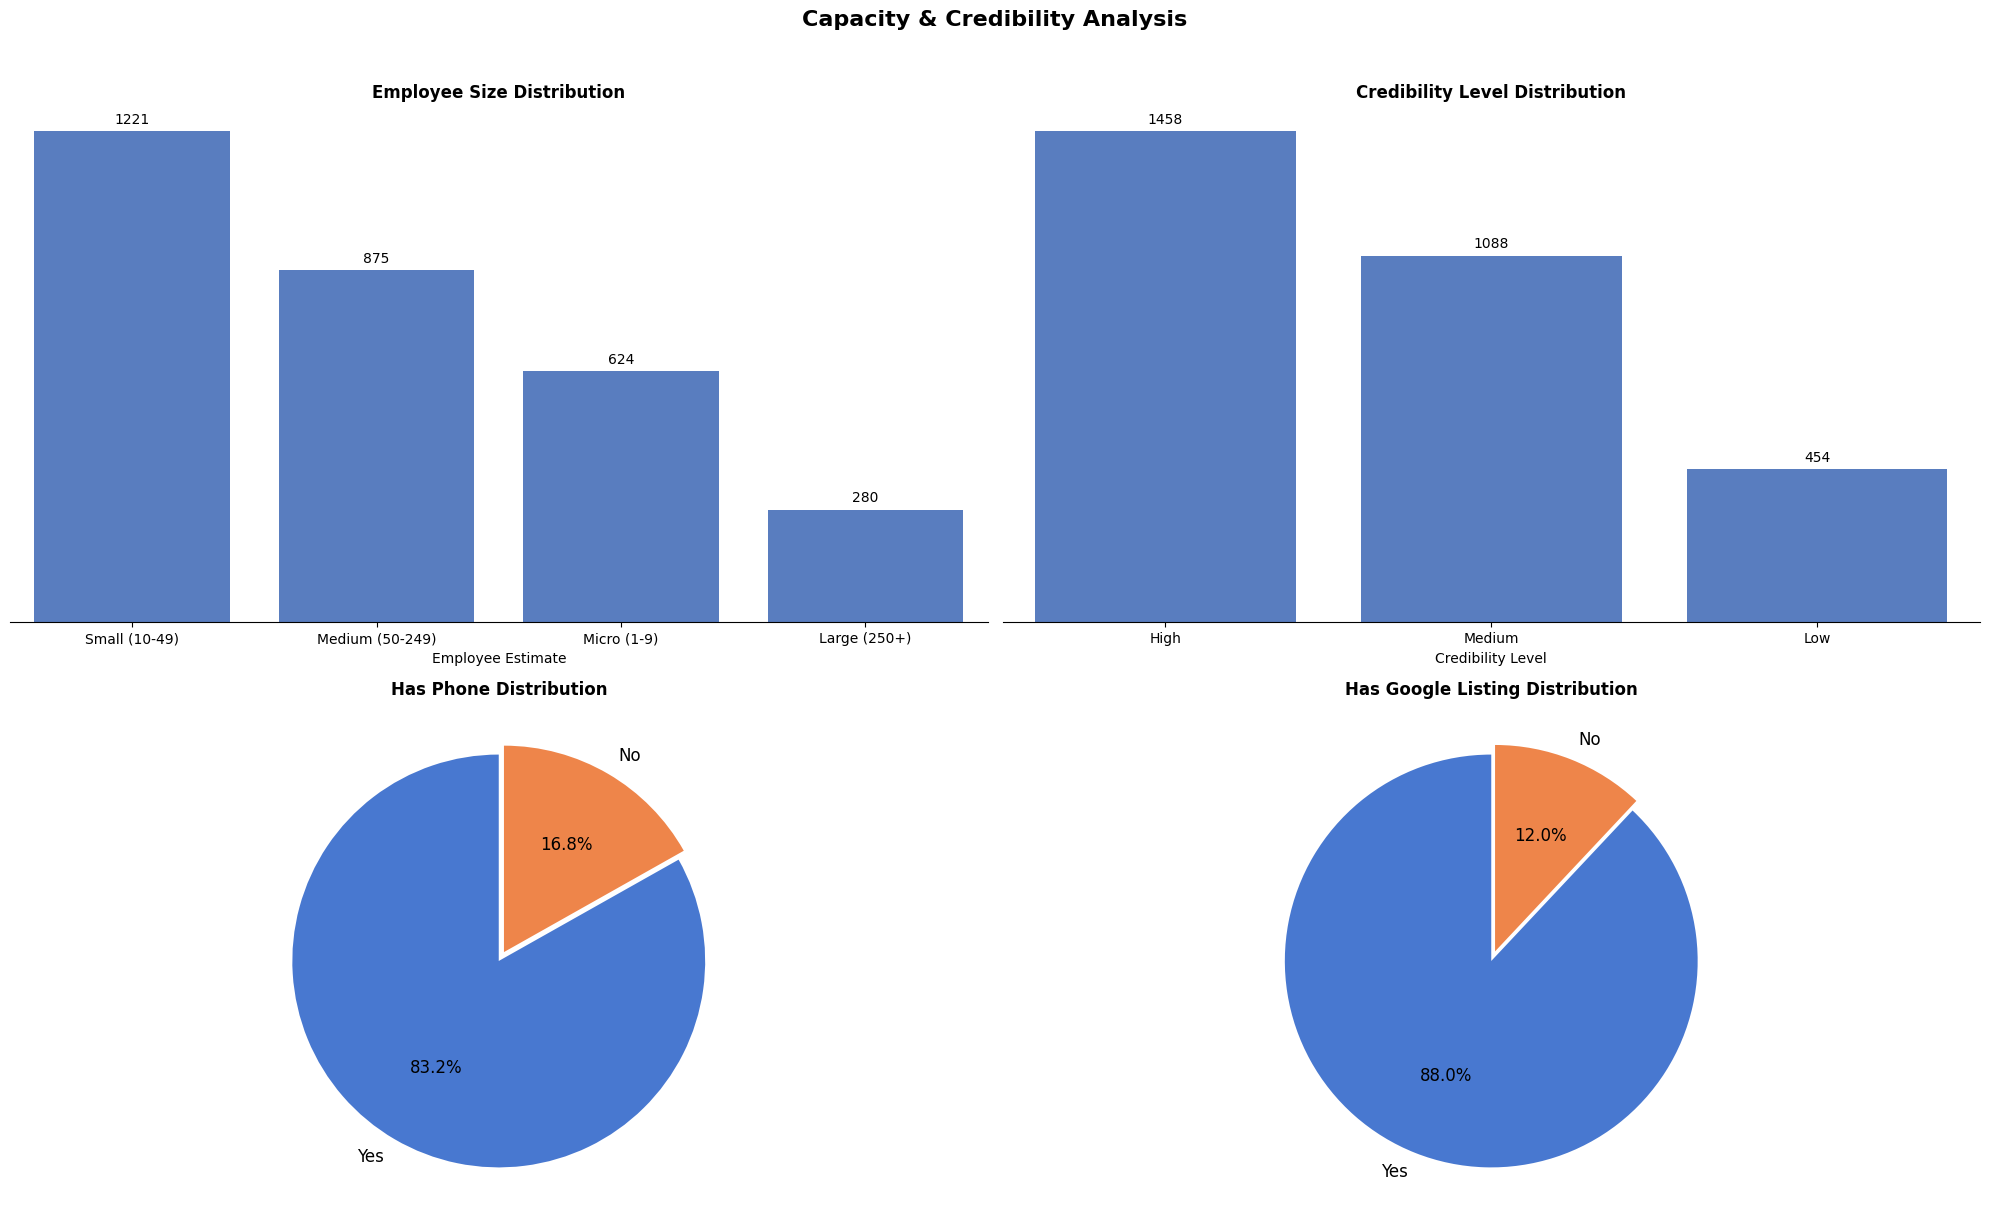

In [11]:
# setting up the plot
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))
fig.suptitle("Capacity & Credibility Analysis", fontsize = 16, fontweight = "bold", y = 1.02)


# plot 01: distribution of "employee_estimate"
sns.countplot(
    data = df,
    x = "employee_estimate",
    order = df["employee_estimate"].value_counts().index,
    ax = axes[0, 0]
)

axes[0, 0].set_title("Employee Size Distribution", fontsize = 12, fontweight = "bold")
axes[0, 0].set_xlabel("Employee Estimate")


# plot 02: distribution of "credibility_level"
sns.countplot(
    data = df,
    x = "credibility_level",
    order = df["credibility_level"].value_counts().index,
    ax = axes[0, 1]
)

axes[0, 1].set_title("Credibility Level Distribution", fontsize = 12, fontweight = "bold")
axes[0, 1].set_xlabel("Credibility Level")


# plot 03: distribution of "has_phone"
phone_counts = df["has_phone"].map({1: "Yes", 0: "No"}).value_counts()
axes[1, 0].pie(
    x = phone_counts.values,
    labels = phone_counts.index,
    autopct = "%1.1f%%",
    startangle = 90,
    explode = (0, 0.05),
    textprops = {"fontsize": 12}
)

axes[1, 0].set_title("Has Phone Distribution", fontsize = 12, fontweight = "bold")


# plot 04: distribution of "has_google_listing" (pie chart)
google_counts = df["has_google_listing"].map({1: "Yes", 0: "No"}).value_counts()
axes[1, 1].pie(
    x = google_counts.values,
    labels = google_counts.index,
    autopct = "%1.1f%%",
    startangle = 90,
    textprops = {"fontsize": 12},
    explode = (0, 0.05)
)
axes[1, 1].set_title("Has Google Listing Distribution", fontsize = 12, fontweight = "bold")


# adding value labels to each bar
for ax in [axes[0, 0], axes[0, 1]]:
    for container in ax.containers:
        ax.bar_label(container = container, label_type = "edge", fontsize = 10, padding = 3)


# customizing the plot aesthetics
for ax in [axes[0, 0], axes[0, 1]]:
    ax.yaxis.set_visible(False)
sns.despine(left = True)
plt.tight_layout()
plt.show()

## Digital Signal

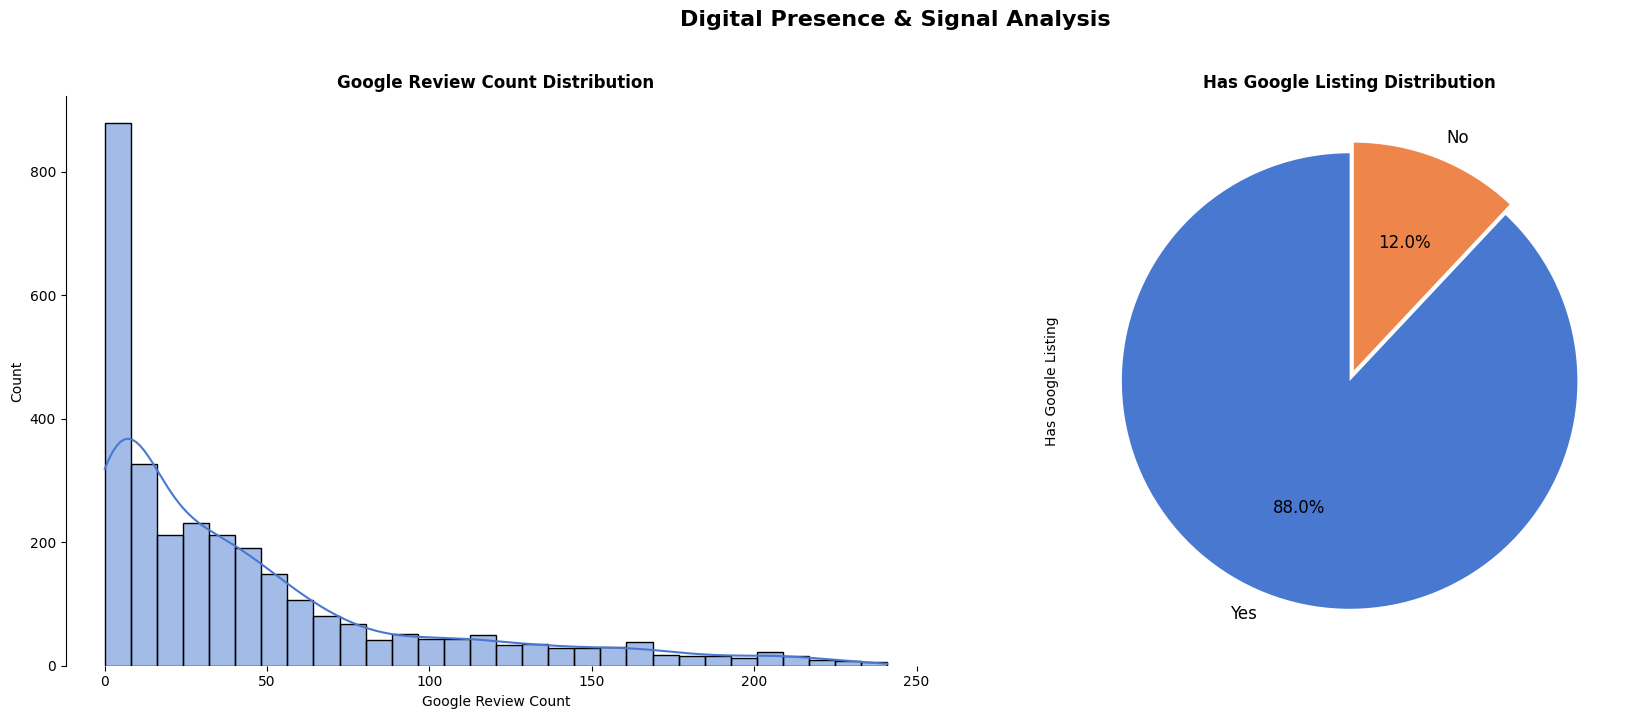

In [12]:
# setting up the plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 7))
fig.suptitle("Digital Presence & Signal Analysis", fontsize = 16, fontweight = "bold", y = 1.02)


# plot 01: distribution of "google_review_count"
sns.histplot(
    data = df,
    x = "google_review_count",
    bins = 30,
    kde = True,
    ax = axes[0]
)

axes[0].set_title("Google Review Count Distribution", fontsize = 12, fontweight = "bold")
axes[0].set_xlabel("Google Review Count")
axes[0].set_ylabel("Count")


# plot 02: distribution of "has_google_listing"
axes[1].pie(
    x = google_counts.values,
    labels = google_counts.index,
    autopct = "%1.1f%%",
    startangle = 90,
    textprops = {"fontsize": 12},
    explode = (0, 0.05)
)

axes[1].set_title("Has Google Listing Distribution", fontsize = 12, fontweight = "bold")
axes[1].set_ylabel("Has Google Listing")


# adding value labels to each bar
for container in axes[1].containers:
    axes[1].bar_label(container = container, label_type = "edge", fontsize = 10, padding = 3)


# customizing the plot aesthetics
axes[1].xaxis.set_visible(False)
sns.despine(bottom = True)
plt.tight_layout()
plt.show()

## Need & Product Fit

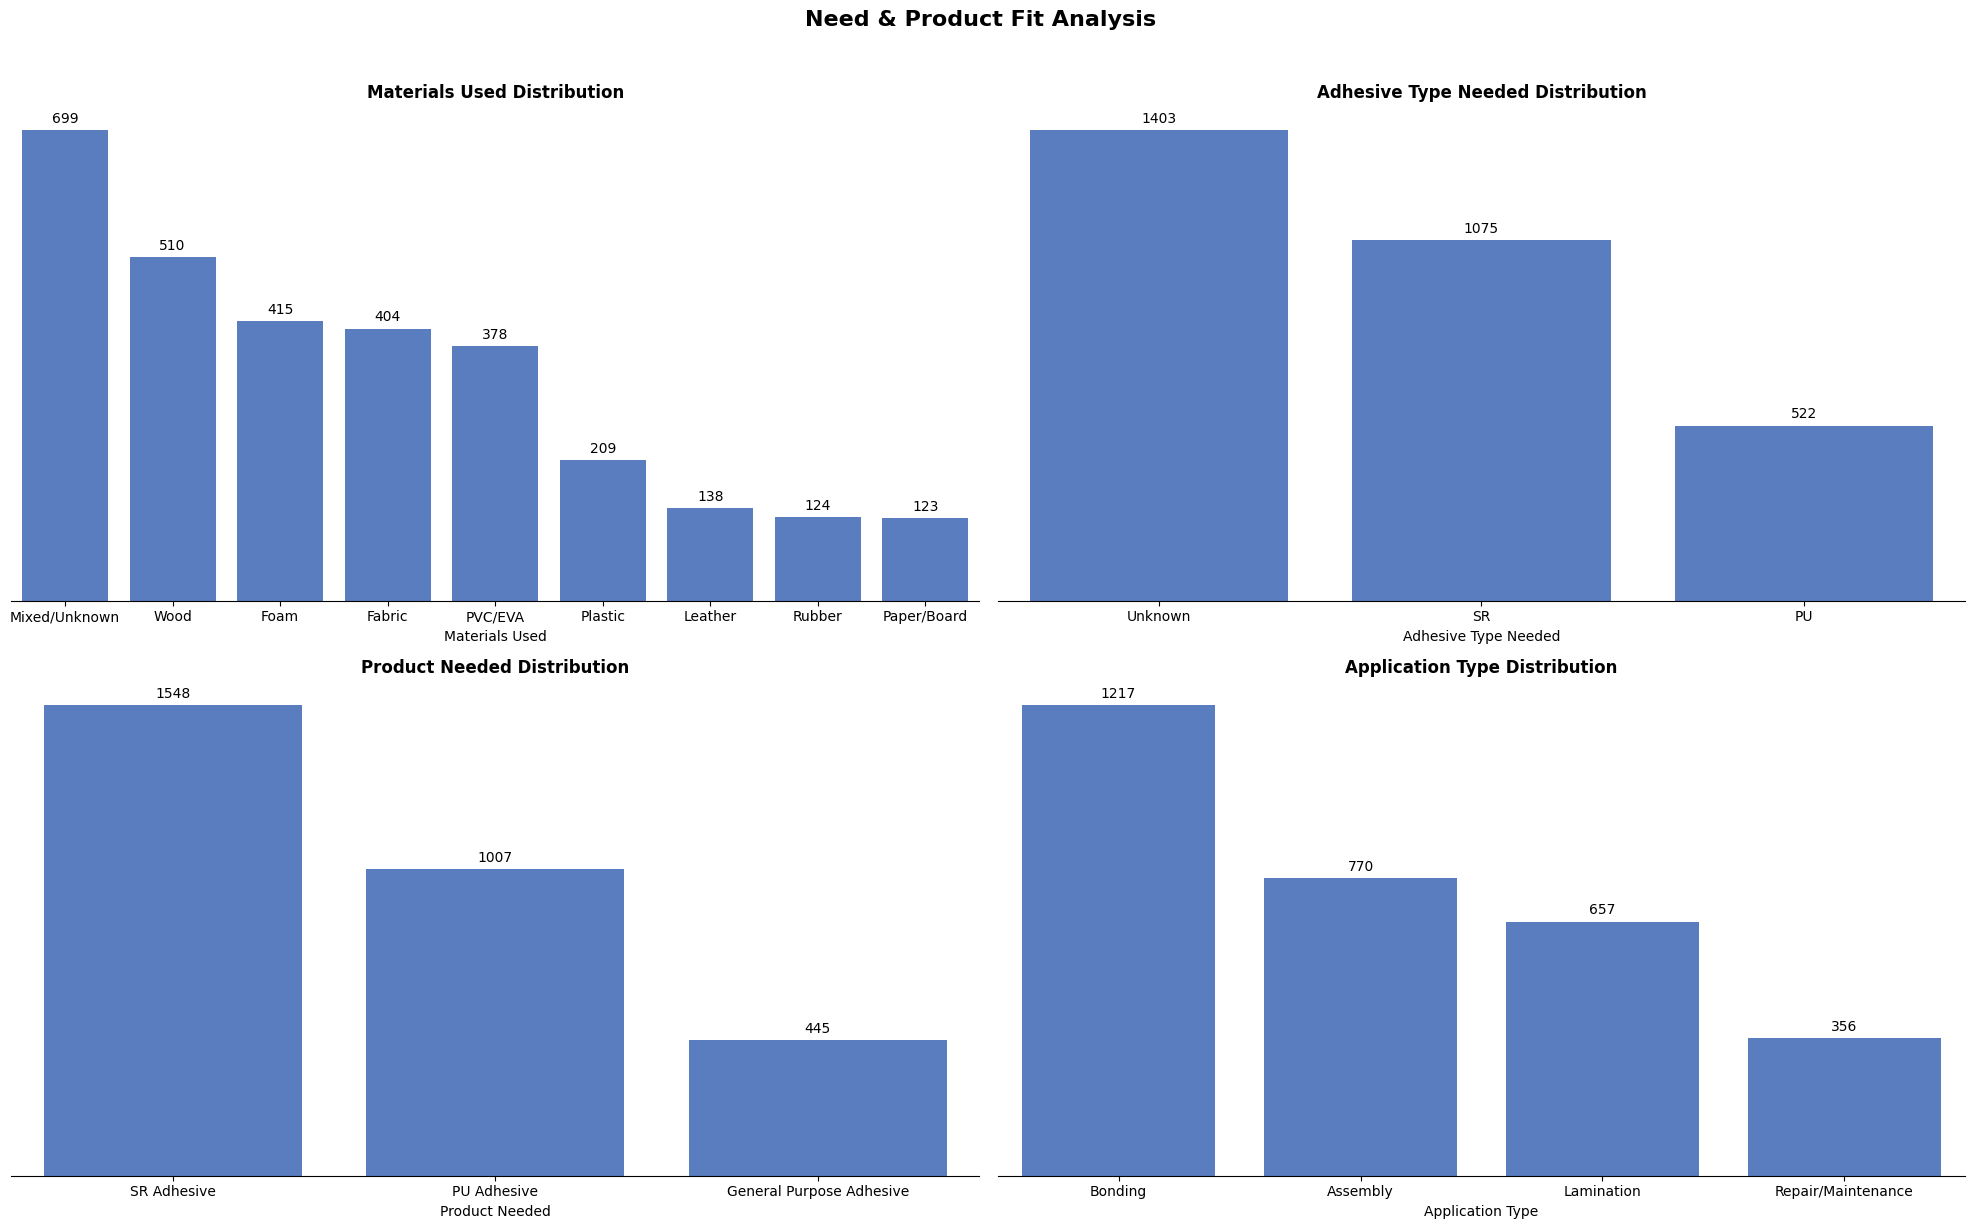

In [13]:
# setting up the plot
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))
fig.suptitle("Need & Product Fit Analysis", fontsize = 16, fontweight = "bold", y = 1.02)


# plot 01: distribution of "materials_used"
sns.countplot(
    data = df,
    x = "materials_used",
    order = df["materials_used"].value_counts().index,
    ax = axes[0, 0]
)

axes[0, 0].set_title("Materials Used Distribution", fontsize = 12, fontweight = "bold")
axes[0, 0].set_xlabel("Materials Used")


# plot 02: distribution of "adhesive_type_needed"
sns.countplot(
    data = df,
    x = "adhesive_type_needed",
    order = df["adhesive_type_needed"].value_counts().index,
    ax = axes[0, 1]
)

axes[0, 1].set_title("Adhesive Type Needed Distribution", fontsize = 12, fontweight = "bold")
axes[0, 1].set_xlabel("Adhesive Type Needed")


# plot 03: distribution of "product_needed"
sns.countplot(
    data = df,
    x = "product_needed",
    order = df["product_needed"].value_counts().index,
    ax = axes[1, 0]
)

axes[1, 0].set_title("Product Needed Distribution", fontsize = 12, fontweight = "bold")
axes[1, 0].set_xlabel("Product Needed")


# plot 04: distribution of "application_type"
sns.countplot(
    data = df,
    x = "application_type",
    order = df["application_type"].value_counts().index,
    ax = axes[1, 1]
)

axes[1, 1].set_title("Application Type Distribution", fontsize = 12, fontweight = "bold")
axes[1, 1].set_xlabel("Application Type")


# adding value labels to each bar
for ax in axes.ravel():
    for container in ax.containers:
        ax.bar_label(container = container, label_type = "edge", fontsize = 10, padding = 3)


# customizing the plot aesthetics
for ax in axes.ravel():
    ax.yaxis.set_visible(False)
sns.despine(left = True)
plt.tight_layout()
plt.show()

## Purchase Behavior & Urgency

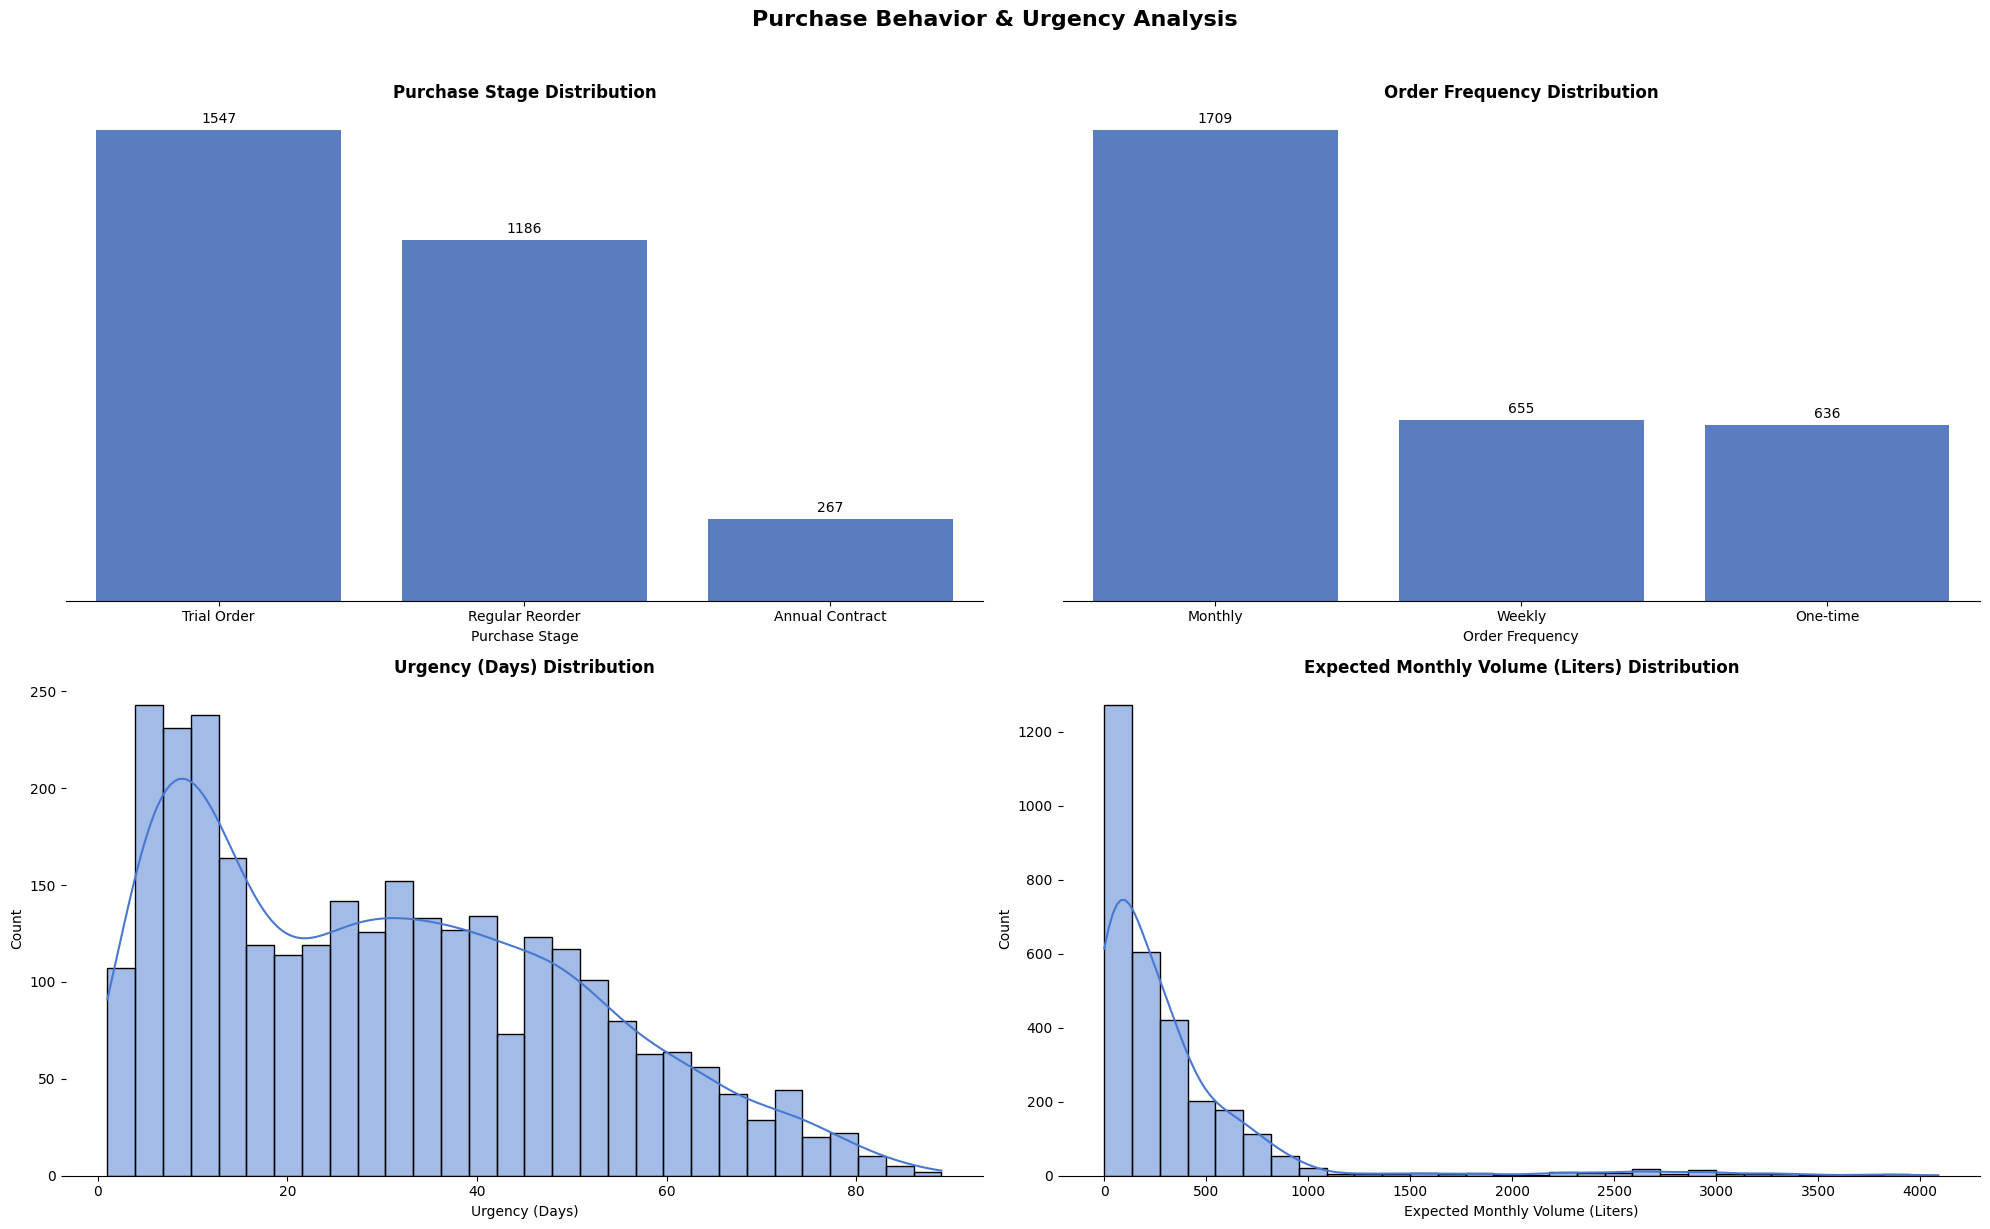

In [14]:
# setting up the plot
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))
fig.suptitle("Purchase Behavior & Urgency Analysis", fontsize = 16, fontweight = "bold", y = 1.02)


# plot 01: distribution of "purchase_stage"
sns.countplot(
    data = df,
    x = "purchase_stage",
    order = df["purchase_stage"].value_counts().index,
    ax = axes[0, 0]
)

axes[0, 0].set_title("Purchase Stage Distribution", fontsize = 12, fontweight = "bold")
axes[0, 0].set_xlabel("Purchase Stage")


# plot 02: distribution of "order_frequency"
sns.countplot(
    data = df,
    x = "order_frequency",
    order = df["order_frequency"].value_counts().index,
    ax = axes[0, 1]
)

axes[0, 1].set_title("Order Frequency Distribution", fontsize = 12, fontweight = "bold")
axes[0, 1].set_xlabel("Order Frequency")


# plot 03: distribution of "urgency_days"
sns.histplot(
    data = df,
    x = "urgency_days",
    bins = 30,
    kde = True,
    ax = axes[1, 0]
)

axes[1, 0].set_title("Urgency (Days) Distribution", fontsize = 12, fontweight = "bold")
axes[1, 0].set_xlabel("Urgency (Days)")
axes[1, 0].set_ylabel("Count")


# plot 04: distribution of "expected_monthly_volume_liters"
sns.histplot(
    data = df,
    x = "expected_monthly_volume_liters",
    bins = 30,
    kde = True,
    ax = axes[1, 1]
)

axes[1, 1].set_title("Expected Monthly Volume (Liters) Distribution", fontsize = 12, fontweight = "bold")
axes[1, 1].set_xlabel("Expected Monthly Volume (Liters)")
axes[1, 1].set_ylabel("Count")


# adding value labels to each bar
for ax in [axes[0, 0], axes[0, 1]]:
    for container in ax.containers:
        ax.bar_label(container = container, label_type = "edge", fontsize = 10, padding = 3)


# customizing the plot aesthetics
for ax in [axes[0, 0], axes[0, 1]]:
    ax.yaxis.set_visible(False)
sns.despine(left = True)
plt.tight_layout()
plt.show()

## Commercial Term & Source

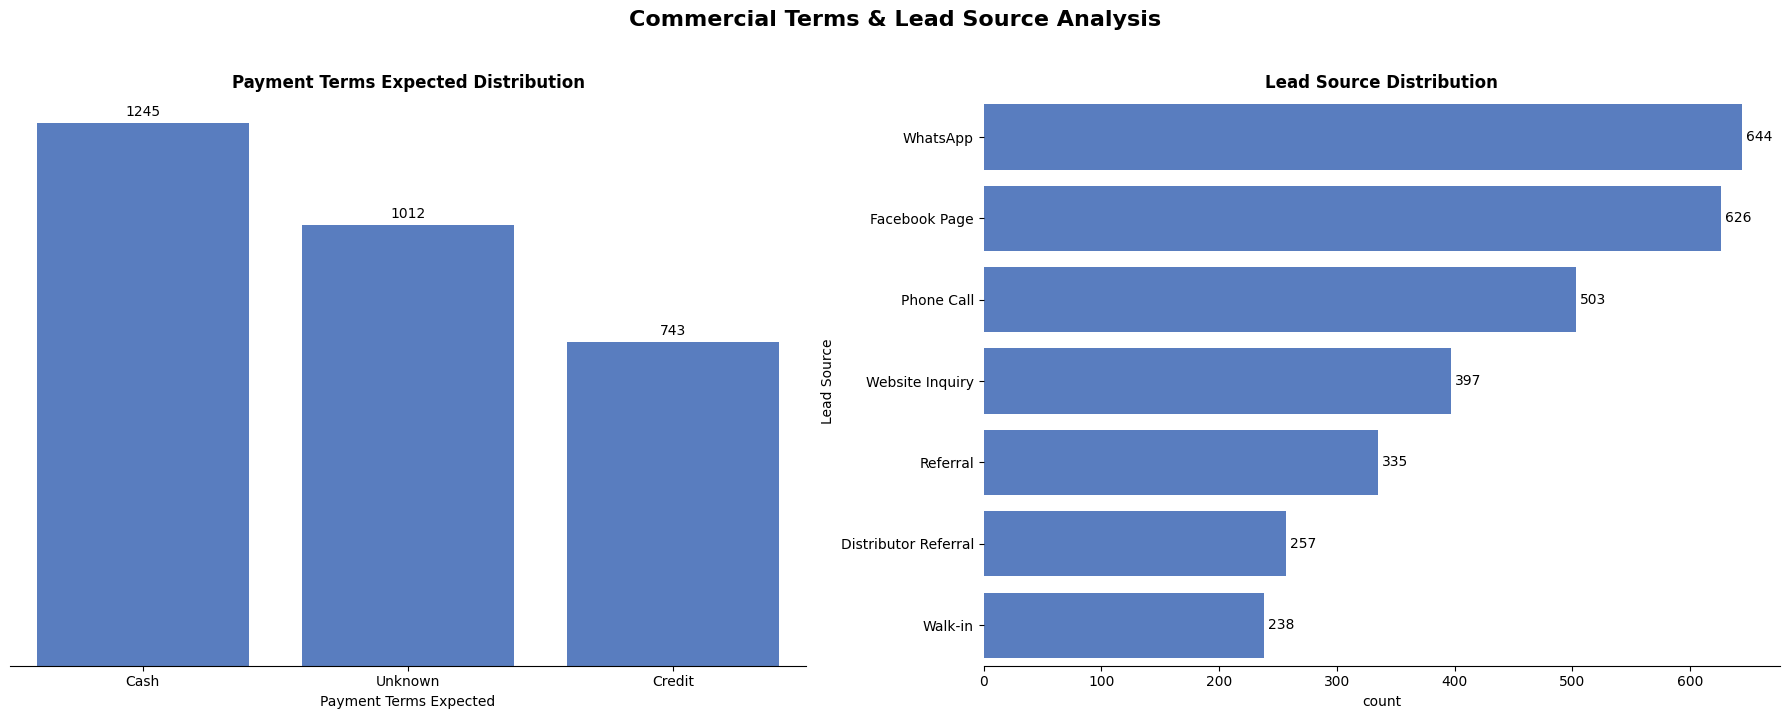

In [15]:
# setting up the plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 7))
fig.suptitle("Commercial Terms & Lead Source Analysis", fontsize = 16, fontweight = "bold", y = 1.02)


# plot 01: distribution of "payment_terms_expected"
sns.countplot(
    data = df,
    x = "payment_terms_expected",
    order = df["payment_terms_expected"].value_counts().index,
    ax = axes[0]
)

axes[0].set_title("Payment Terms Expected Distribution", fontsize = 12, fontweight = "bold")
axes[0].set_xlabel("Payment Terms Expected")


# plot 02: distribution of "lead_source"
sns.countplot(
    data = df,
    y = "lead_source",
    order = df["lead_source"].value_counts().index,
    ax = axes[1]
)

axes[1].set_title("Lead Source Distribution", fontsize = 12, fontweight = "bold")
axes[1].set_ylabel("Lead Source")


# adding value labels to each bar
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container = container, label_type = "edge", fontsize = 10, padding = 3)


# customizing the plot aesthetics
axes[0].yaxis.set_visible(False)
sns.despine(left = True)
plt.tight_layout()
plt.show()

## Numerical Features

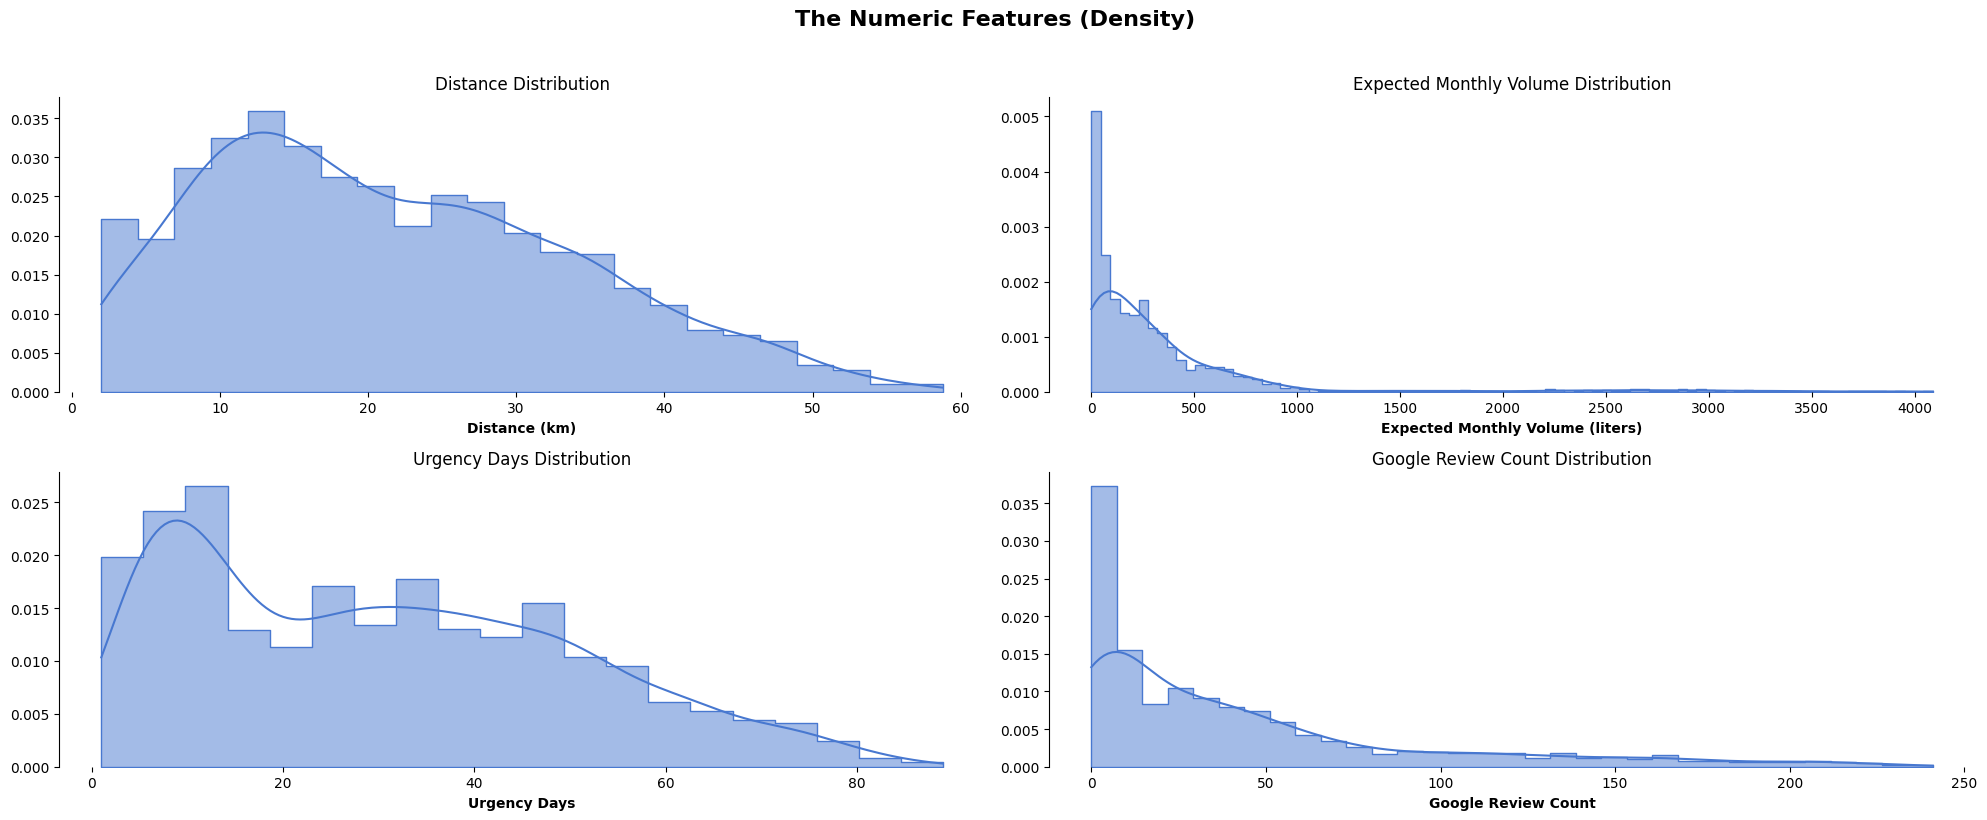

In [16]:
# setting up the plot
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 8))
fig.suptitle("The Numeric Features (Density)", fontsize = 16, fontweight = "bold", y = 1.02)

# plot 01: visualizing the distribution of the target variable "industry_category"
sns.histplot(data = df["distance_km"], kde = True, element = "step", stat = "density", ax = axes[0, 0])

axes[0, 0].set_title("Distance Distribution", fontsize = 12)
axes[0, 0].set_xlabel("Distance (km)", fontweight = "bold")
axes[0, 0].set_ylabel("")


# plot 02: visualizing the top ten "sub_industry"
sns.histplot(data = df["expected_monthly_volume_liters"], kde = True, element = "step", stat = "density", ax = axes[0, 1])

axes[0, 1].set_title("Expected Monthly Volume Distribution", fontsize = 12)
axes[0, 1].set_xlabel("Expected Monthly Volume (liters)", fontweight = "bold")
axes[0, 1].set_ylabel("")

# plot 03: visualizing the distribution of "company_type"
sns.histplot(data = df["urgency_days"], kde = True, element = "step", stat = "density", ax = axes[1, 0])

axes[1, 0].set_title("Urgency Days Distribution", fontsize = 12)
axes[1, 0].set_xlabel("Urgency Days", fontweight = "bold")
axes[1, 0].set_ylabel("")

# plot 04: visualizing the distribution of "company_type"
sns.histplot(data = df["google_review_count"], kde = True, element = "step", stat = "density", ax = axes[1, 1])

axes[1, 1].set_title("Google Review Count Distribution", fontsize = 12)
axes[1, 1].set_xlabel("Google Review Count", fontweight = "bold")
axes[1, 1].set_ylabel("")

# adding value labels to each bar
for ax in axes.flat:
    for container in ax.containers:
        ax.bar_label(container = container, label_type = "edge", fontsize = 10, padding = 3)

# customizing the plot aesthetics
sns.despine(bottom = True)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

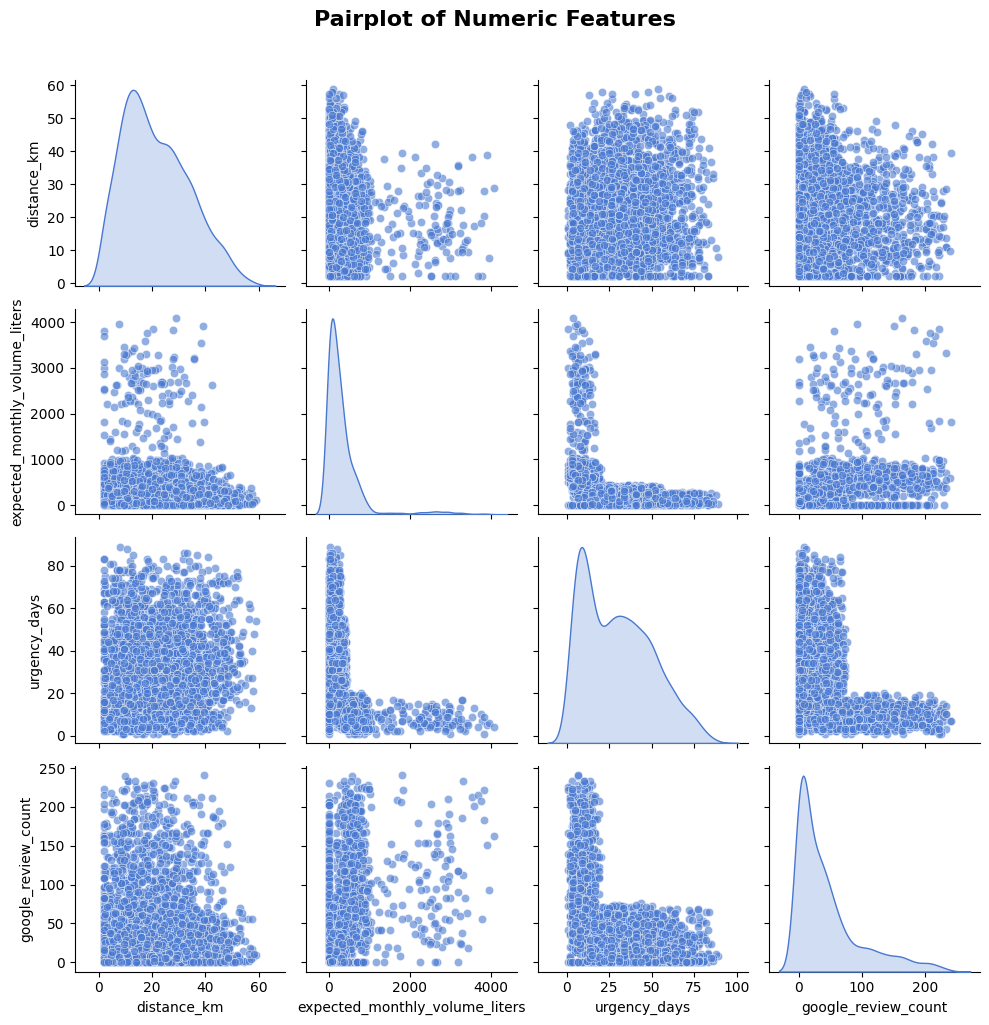

In [17]:
# Setting up the plot
plt.figure(figsize = (14, 6))

# creating a pairplot to visualize the relationships between the numeric features
sns.pairplot(
    data = df,
    vars = ["distance_km", "expected_monthly_volume_liters", "urgency_days", "google_review_count",
],
    diag_kind = "kde",
    plot_kws = {"alpha": 0.6}
)

# Customizing the plot
plt.suptitle("Pairplot of Numeric Features", fontsize = 16, fontweight = "bold", y = 1.02)
plt.tight_layout()
plt.show()

# **Machine Learning**

## Data Preparation

In [18]:
# deciding x and y
y = df["lead_bucket"]
X = df.drop(columns = ["company_name", "lead_bucket", "lead_score"])

In [19]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 49, stratify = y)

### **Encoding**

First, we classified the features into three categories: **ordinal**, **nominal**, and **numerical**. We then applied appropriate encoding techniques to each category to prepare the data for modeling.

In [20]:
# numeric columns
numeric_cols = [
    "distance_km",
    "expected_monthly_volume_liters",
    "urgency_days",
    "google_review_count",
]

# ordinal columns
ordinal_cols = ["employee_estimate", "credibility_level", "purchase_stage"]

# one-hot columns
onehot_cols = [c for c in X.columns if c not in numeric_cols + ordinal_cols]

#### Ordinal Encoding

In [21]:
# importing the library
from sklearn.preprocessing import OrdinalEncoder

# extracting the ordinal mappings from the categorical columns
ordinal_mappings = {
    col: X_train[col].cat.categories.tolist() for col in ordinal_cols
}

# creating OrdinalEncoder
ordinal_encoder = OrdinalEncoder(
    categories = [ordinal_mappings[col] for col in ordinal_cols],
    handle_unknown = "use_encoded_value",
    unknown_value = -1
)

# fitting & transforming
X_train[ordinal_cols] = ordinal_encoder.fit_transform(X = X_train[ordinal_cols])
X_test[ordinal_cols] = ordinal_encoder.transform(X = X_test[ordinal_cols])

#### One-Hot Encoding

In [22]:
# importing the library
from sklearn.preprocessing import OneHotEncoder

# creating OneHotEncoder
onehot_encoder = OneHotEncoder(
    sparse_output = False,
    handle_unknown = "ignore",
    drop = "first"
)

# fitting & transforming
onehot_encoded_train = pd.DataFrame(
    onehot_encoder.fit_transform(X = X_train[onehot_cols]),
    columns = onehot_encoder.get_feature_names_out(onehot_cols),
    index = X_train.index
)

onehot_encoded_test = pd.DataFrame(
    onehot_encoder.transform(X = X_test[onehot_cols]),
    columns = onehot_encoder.get_feature_names_out(onehot_cols),
    index = X_test.index
)

# dropping original columns & concatenating encoded columns
X_train = X_train.drop(columns = onehot_cols).join(onehot_encoded_train)
X_test = X_test.drop(columns = onehot_cols).join(onehot_encoded_test)

### **Standardization**

In [23]:
# scaling the numeric columns using standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X = X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X = X_test[numeric_cols])

## Modeling

### **Multinomial Logistic Regression**

In [24]:
# importing the library
from sklearn.linear_model import LogisticRegression

# creating the model object
log_model = LogisticRegression(
    solver = "lbfgs",
    max_iter = 2000,
    random_state = 49
)

# fitting the model
log_model.fit(X = X_train, y = y_train)

# predicting the target variable
y_pred_log = log_model.predict(X = X_test)

In [25]:
# importing the necessary libraries
from sklearn.metrics import accuracy_score, classification_report

# calculating the accuracy scores for test dataset
accuracy_log = accuracy_score(y_true = y_test, y_pred = y_pred_log)

# generating the Classification reports for test dataset
report_log = classification_report(y_true = y_test, y_pred = y_pred_log)

# printing a comprehensive summary Report
print(
f"""Model Performance Report for Multinomial Logistic Regression
Accuracy Score: {accuracy_log:.2%}

{report_log}"""
)

Model Performance Report for Multinomial Logistic Regression
Accuracy Score: 73.33%

                precision    recall  f1-score   support

          Cold       0.71      0.72      0.71       245
           Hot       0.64      0.57      0.60        88
        Reject       0.78      0.90      0.84       175
Save For Later       0.73      0.60      0.66       186
          Warm       0.76      0.80      0.78       206

      accuracy                           0.73       900
     macro avg       0.72      0.72      0.72       900
  weighted avg       0.73      0.73      0.73       900



<div style = "text-align: justify;">

**Key Insights:**

* Multinomial Logistic Regression achieves **73.33% accuracy** with **macro F1 0.72** and **weighted F1 0.73**, indicating fairly consistent performance across classes.
* The model performs strongly on **Reject (recall 0.90, F1 0.84)** and **Warm (recall 0.80, F1 0.77)**, but struggles most with **Hot (recall 0.56, F1 0.59)**, meaning it misses a meaningful share of high-priority leads.
* Cold is moderate and stable (**F1 0.71**), while Save For Later is weaker (**recall 0.66**). 
* Overall, this is a solid baseline, but improving **Hot recall** would increase business usefulness.

</div>

<div style = "text-align: justify;">

As this is a multiclass classification problem, we will use the One-vs-Rest (**OVR**) strategy to compute the ROC-AUC scores. **Three** of the approaches are:

1. **OVR Macro AUC:** Average one-vs-rest (OVR) ROC-AUC across all classes (each class gets equal weight); used to judge overall multiclass separability fairly, especially when classes are imbalanced.
2. **OVR Weighted AUC:** One-vs-rest ROC-AUC averaged across classes but weighted by how frequent each class is; used to summarize multiclass performance in a way that reflects the real class distribution.
3. **Qualified-vs-Not AUC:** ROC-AUC after collapsing buckets into “Qualified” (e.g., Hot + Warm) vs “Not Qualified” (others); used to evaluate the core business question: can we prioritize good leads above the rest?

</div>

In [26]:
## this code is created with the help of AI

# calculating predicted probabilities
y_prob_log = log_model.predict_proba(X = X_test)

# importing the necessary library for ROC-AUC calculation
from sklearn.metrics import roc_auc_score

# calculating ROC-AUC score using One-vs-Rest (OVR) strategy with macro averaging
auc_macro_ovr_log = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_log,
    multi_class = "ovr",
    average = "macro"
)

# calculating ROC-AUC score using OVR strategy with weighted averaging
auc_weighted_ovr_log = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_log,
    multi_class = "ovr",
    average = "weighted"
)

# printing the ROC-AUC scores
print(f"OVR macro ROC-AUC for Multinomial Logistic Regression: {auc_macro_ovr_log: .2%}")
print(f"OVR weighted ROC-AUC for Multinomial Logistic Regression: {auc_weighted_ovr_log: .2%}")

OVR macro ROC-AUC for Multinomial Logistic Regression:  93.46%
OVR weighted ROC-AUC for Multinomial Logistic Regression:  92.84%


<div style = "text-align: justify;">

**Key Insights:**

* Logistic Regression shows **strong multiclass discrimination**, with an OVR Macro AUC of **93.46%**, meaning it can separate each bucket from the rest well **on average**.
* The OVR Weighted AUC of **92.85%** is slightly lower, indicating performance is influenced by the more common buckets and may be a bit weaker on harder/less frequent classes. Together, these suggest the model ranks leads reliably across all five outcomes, not just one or two easy classes.

</div>

In [27]:
## this code is created with the help of AI

# importing the necessary libraries for ROC curve calculation
from sklearn.metrics import roc_curve

# defining qualified lead classes for binary ROC-AUC evaluation
qualified = {"Hot", "Warm"}

# converting multiclass labels to binary: 1 = qualified (Hot/Warm), 0 = not qualified
y_test_bin_auc = np.array([1 if y in qualified else 0 for y in y_test])

# getting the class order from the logistic regression model
class_order_log = log_model.classes_

# finding the column indices for "Hot" and "Warm" in the probability matrix
qualified_idx_log = [np.where(class_order_log == c)[0][0] for c in qualified]

# summing the predicted probabilities of "Hot" and "Warm" to get P(Qualified)
p_qualified_log = y_prob_log[:, qualified_idx_log].sum(axis = 1)

# computing the ROC curve (FPR, TPR) for qualified-vs-not binary classification
fpr, tpr, _ = roc_curve(y_true = y_test_bin_auc, y_score = p_qualified_log)

# calculating the ROC-AUC score for qualified-vs-not binary classification
auc_score_log = roc_auc_score(y_true = y_test_bin_auc, y_score = p_qualified_log)

# printing the qualified-vs-not ROC-AUC score
print(f"Qualified-vs-Not ROC-AUC for Multinomial Logistic Regression: {auc_score_log:.2%}")

Qualified-vs-Not ROC-AUC for Multinomial Logistic Regression: 98.87%


<div style = "text-align: justify;">

**Key Insight:** A Qualified-vs-Not AUC of **98.87%** means the model is excellent at distinguishing high-value leads (Hot/Warm) from the rest. In practical terms, it can rank a qualified lead above a non-qualified lead almost all the time, which is exactly what a lead triage system needs.

</div>

<div style = "text-align: justify;">

**Overall Key Insights from all the ROC-AUC Scores:**

* Taken together, the AUC results show **two** things:
    1. The model performs well as a full 5-bucket classifier (macro/weighted AUC ≈ 0.93)
    2. It performs even better on the business-critical decision of “prioritize vs deprioritize” (Qualified-vs-Not AUC ≈ 0.99).
* The small gap between macro and weighted AUC suggests some buckets are slightly harder than others (typically the “middle” buckets).
* Overall, these scores indicate the model is strong for ranking and prioritization, with particularly high reliability when used as a screening tool for qualified leads.

</div>

<div style = "text-align: justify;">

***From our next model, we will skip the key insights section(s) to avoid redundancy. After running all the models, we will summarize the performance metrics in a comparative table, generate an overall key insights section, and select the best model for deployment.***

</div>

### **Random Forest Classifier**

In [28]:
# importing the library
from sklearn.ensemble import RandomForestClassifier

# initializing the model
rf_model = RandomForestClassifier(
    
    # Tree structure
    n_estimators = 500,          # Number of trees in the forest
    max_depth = 20,              # Maximum depth of each tree
    min_samples_split = 20,      # Minimum samples to split a node
    min_samples_leaf = 10,       # Minimum samples in a leaf
    max_features = "sqrt",       # Number of features for best split
    
    # Regularization
    max_samples = 0.8,           # Fraction of samples for each tree (bootstrap)
    min_impurity_decrease = 0.0, # Minimum impurity decrease for split
    
    # Bootstrap sampling
    bootstrap = True,            # Use bootstrap sampling
    oob_score = False,           # Out-of-bag score (set True if needed)
    
    # System
    random_state = 49,           # For reproducibility
    n_jobs = -1,                 # Use all CPU cores
    verbose = 0                  # Silent mode
)

# fitting the model
rf_model.fit(X = X_train, y = y_train)

# predicting the target variable
y_pred_rf = rf_model.predict(X = X_test)

In [29]:
# calculating the accuracy scores for test dataset
accuracy_rf = accuracy_score(y_true = y_test, y_pred = y_pred_rf)

# generating the Classification reports for test dataset
report_rf = classification_report(y_true = y_test, y_pred = y_pred_rf)

# printing a comprehensive summary Report
print(
f"""Model Performance Report for Random Forest Classifier
Accuracy Score: {accuracy_rf:.2%}

{report_rf}"""
)

Model Performance Report for Random Forest Classifier
Accuracy Score: 75.44%

                precision    recall  f1-score   support

          Cold       0.77      0.72      0.75       245
           Hot       0.86      0.22      0.35        88
        Reject       0.78      0.99      0.87       175
Save For Later       0.79      0.60      0.68       186
          Warm       0.70      0.96      0.81       206

      accuracy                           0.75       900
     macro avg       0.78      0.70      0.69       900
  weighted avg       0.77      0.75      0.73       900



In [30]:
# calculating predicted probabilities
y_prob_rf = rf_model.predict_proba(X = X_test)

# calculating the OVR macro ROC-AUC scores
auc_macro_ovr_rf = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_rf,
    multi_class = "ovr",
    average = "macro"
)

# calculating the OVR weighted ROC-AUC scores
auc_weighted_ovr_rf = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_rf,
    multi_class = "ovr",
    average = "weighted"
)

# printing the ROC-AUC scores
print(f"OVR macro ROC-AUC score for Random Forest Classifier:{auc_macro_ovr_rf: .2%}")
print(f"OVR weighted ROC-AUC score for Random Forest Classifier:{auc_weighted_ovr_rf: .2%}")

OVR macro ROC-AUC score for Random Forest Classifier: 94.51%
OVR weighted ROC-AUC score for Random Forest Classifier: 93.83%


In [31]:
# calculating ROC-AUC score for qualified-vs-not binary classification
class_order_rf = rf_model.classes_
qualified_idx_rf = [np.where(class_order_rf == c)[0][0] for c in qualified]
p_qualified_rf = y_prob_rf[:, qualified_idx_rf].sum(axis = 1)

fpr, tpr, _ = roc_curve(y_true = y_test_bin_auc, y_score = p_qualified_rf)
auc_score_rf = roc_auc_score(y_true = y_test_bin_auc, y_score = p_qualified_rf)

# printing the qualified-vs-not ROC-AUC score
print(f"Qualified-vs-Not ROC-AUC for Random Forest Classifier: {auc_score_rf:.2%}")

Qualified-vs-Not ROC-AUC for Random Forest Classifier: 98.85%


### **LightGBM Classifier**

In [32]:
# importing the library
from lightgbm import LGBMClassifier

# initializing the model
lgbm_model = LGBMClassifier(

    # Tree structure
    n_estimators = 1000,        # Number of boosting rounds
    learning_rate = 0.05,       # Step size shrinkage
    max_depth = 10,             # Setting the tree depth
    num_leaves = 50,            # Controls tree complexity

    # Regularization
    min_child_samples = 20,     # Minimum data in a leaf
    subsample = 0.8,            # Fraction of rows per tree
    colsample_bytree = 0.8,     # Fraction of features per tree
    reg_alpha = 0.1,            # Shrink coefficients
    reg_lambda = 0.1,           # Shrink coefficients
    subsample_freq = 1,         # How often to do row sampling

    # System
    random_state = 49,          # For reproducability
    n_jobs = 1,                 # CPU cores
    verbose = -1                # Suppress output
)

# fitting the model
lgbm_model.fit(X = X_train, y = y_train)

# predicting the target variable
y_pred_lgbm = lgbm_model.predict(X = X_test)

In [33]:
# calculating the accuracy scores for test dataset
accuracy_lgbm = accuracy_score(y_true = y_test, y_pred = y_pred_lgbm)

# generating the Classification reports for test dataset
report_lgbm = classification_report(y_true = y_test, y_pred = y_pred_lgbm)

# printing a comprehensive summary Report
print(
f"""Model Performance Report for LightGBM Classifier
Accuracy Score: {accuracy_lgbm:.2%}

{report_lgbm}"""
)

Model Performance Report for LightGBM Classifier
Accuracy Score: 74.78%

                precision    recall  f1-score   support

          Cold       0.73      0.66      0.70       245
           Hot       0.65      0.64      0.64        88
        Reject       0.81      0.92      0.86       175
Save For Later       0.71      0.68      0.69       186
          Warm       0.78      0.82      0.80       206

      accuracy                           0.75       900
     macro avg       0.74      0.74      0.74       900
  weighted avg       0.74      0.75      0.74       900



In [34]:
# calculating predicted probabilities
y_prob_lgbm = lgbm_model.predict_proba(X = X_test)

# calculating the OVR macro ROC-AUC scores
auc_macro_ovr_lgbm = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_lgbm,
    multi_class = "ovr",
    average = "macro"
)

# calculating the OVR weighted ROC-AUC scores
auc_weighted_ovr_lgbm = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_lgbm,
    multi_class = "ovr",
    average = "weighted"
)

print(f"OVR macro ROC-AUC score for LightGBM Classifier:{auc_macro_ovr_lgbm: .2%}")
print(f"OVR weighted ROC-AUC score for LightGBM Classifier:{auc_weighted_ovr_lgbm: .2%}")

OVR macro ROC-AUC score for LightGBM Classifier: 94.21%
OVR weighted ROC-AUC score for LightGBM Classifier: 93.69%


In [35]:
# calculating ROC-AUC score for qualified-vs-not binary classification
class_order_lgbm = lgbm_model.classes_
qualified_idx_lgbm = [np.where(class_order_lgbm == c)[0][0] for c in qualified]
p_qualified_lgbm = y_prob_lgbm[:, qualified_idx_lgbm].sum(axis = 1)

fpr, tpr, _ = roc_curve(y_true = y_test_bin_auc, y_score = p_qualified_lgbm)
auc_score_lgbm = roc_auc_score(y_true = y_test_bin_auc, y_score = p_qualified_lgbm)

# printing the qualified-vs-not ROC-AUC score
print(f"Qualified-vs-Not ROC-AUC for LightGBM Classifier: {auc_score_lgbm:.2%}")

Qualified-vs-Not ROC-AUC for LightGBM Classifier: 98.93%


### **CatBoost Classifier**

In [36]:
# importing the library
from catboost import CatBoostClassifier

# Initializing the model
cat_model = CatBoostClassifier(

    # Tree structure
    iterations = 1000,              # Number of boosting rounds
    learning_rate = 0.05,           # Step size shrinkage
    depth = 7,                      # Maximum tree depth
    
    # Regularization
    l2_leaf_reg = 3,                # L2 regularization coefficient
    border_count = 128,             # Number of splits for numerical features
    random_strength = 1,            # Randomness for scoring splits
    
    # Sampling
    subsample = 0.8,                # Fraction of rows per tree
    bootstrap_type = "Bernoulli",   # Type of bootstrap
    
    # System
    random_state = 49,              # For reproducibility
    thread_count = 1,               # Single-threaded for determinism
    verbose = False,                # Silent mode
    allow_writing_files = False,    # Don't write training files
    task_type = "CPU"               # Force CPU mode
)

# fitting the model
cat_model.fit(X = X_train, y = y_train)

# predicting the target variable
y_pred_cat = cat_model.predict(X_test)

In [37]:
# calculating the accuracy scores for test dataset
accuracy_cat = accuracy_score(y_true = y_test, y_pred = y_pred_cat)

# generating the Classification reports for test dataset
report_cat = classification_report(y_true = y_test, y_pred = y_pred_cat)

# printing a comprehensive summary Report
print(
f"""Model Performance Report for CatBoost Classifier
Accuracy Score: {accuracy_cat:.2%}

{report_cat}"""
)

Model Performance Report for CatBoost Classifier
Accuracy Score: 78.78%

                precision    recall  f1-score   support

          Cold       0.78      0.70      0.74       245
           Hot       0.71      0.78      0.75        88
        Reject       0.79      0.97      0.87       175
Save For Later       0.78      0.69      0.73       186
          Warm       0.84      0.83      0.83       206

      accuracy                           0.79       900
     macro avg       0.78      0.79      0.78       900
  weighted avg       0.79      0.79      0.78       900



In [38]:
# calculating predicted probabilities
y_prob_cat = cat_model.predict_proba(X = X_test)

# calculating the OVR macro ROC-AUC scores
auc_macro_ovr_cat = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_cat,
    multi_class = "ovr",
    average = "macro"
)

# calculating the OVR weighted ROC-AUC scores
auc_weighted_ovr_cat = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_cat,
    multi_class = "ovr",
    average = "weighted"
)

# printing the ROC-AUC scores
print(f"OVR macro ROC-AUC score for CatBoost Classifier:{auc_macro_ovr_cat: .2%}")
print(f"OVR weighted ROC-AUC score for CatBoost Classifier:{auc_weighted_ovr_cat: .2%}")

OVR macro ROC-AUC score for CatBoost Classifier: 95.29%
OVR weighted ROC-AUC score for CatBoost Classifier: 94.77%


In [39]:
# calculating ROC-AUC score for qualified-vs-not binary classification
class_order_cat = cat_model.classes_
qualified_idx_cat = [np.where(class_order_cat == c)[0][0] for c in qualified]
p_qualified_cat = y_prob_cat[:, qualified_idx_cat].sum(axis = 1)

fpr, tpr, _ = roc_curve(y_true = y_test_bin_auc, y_score = p_qualified_cat)
auc_score_cat = roc_auc_score(y_true = y_test_bin_auc, y_score = p_qualified_cat)

# printing the qualified-vs-not ROC-AUC score
print(f"Qualified-vs-Not ROC-AUC for CatBoost Classifier: {auc_score_cat:.2%}")

Qualified-vs-Not ROC-AUC for CatBoost Classifier: 99.01%


### **Histogram-based Gradient Boosting Classifier**

In [40]:
# importing the library
from sklearn.ensemble import HistGradientBoostingClassifier

# initializing the model
hgb_model = HistGradientBoostingClassifier(

    # Tree structure
    max_iter = 1000,                # Number of boosting rounds
    learning_rate = 0.05,           # Step size shrinkage
    max_depth = 5,                  # Maximum tree depth
    
    # Regularization
    min_samples_leaf = 10,          # Minimum samples in a leaf
    max_features = 0.8,            # Fraction of features for best split
    
    # Loss function
    loss = "log_loss",              # Cross-entropy for classification
    
    # System
    random_state = 49,              # For reproducibility
    verbose = 0                     # Silent mode
)

# fitting the model
hgb_model.fit(X = X_train, y = y_train)

# predicting the target variable
y_pred_hgb = hgb_model.predict(X = X_test)

In [41]:
# calculating the accuracy scores for test dataset
accuracy_hgb = accuracy_score(y_true = y_test, y_pred = y_pred_hgb)

# generating the Classification reports for test dataset
report_hgb = classification_report(y_true = y_test, y_pred = y_pred_hgb)

# printing a comprehensive summary Report
print(
f"""Model Performance Report for HistGradientBoosting Classifier
Accuracy Score: {accuracy_hgb:.2%}

{report_hgb}"""
)

Model Performance Report for HistGradientBoosting Classifier
Accuracy Score: 74.56%

                precision    recall  f1-score   support

          Cold       0.73      0.67      0.70       245
           Hot       0.62      0.64      0.63        88
        Reject       0.80      0.94      0.86       175
Save For Later       0.72      0.67      0.70       186
          Warm       0.78      0.79      0.78       206

      accuracy                           0.75       900
     macro avg       0.73      0.74      0.73       900
  weighted avg       0.74      0.75      0.74       900



In [42]:
# calculating predicted probabilities
y_prob_hgb = hgb_model.predict_proba(X = X_test)

# calculating the OVR macro ROC-AUC scores
auc_macro_ovr_hgb = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_hgb,
    multi_class = "ovr",
    average = "macro"
)

# calculating the OVR weighted ROC-AUC scores
auc_weighted_ovr_hgb = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_hgb,
    multi_class = "ovr",
    average = "weighted"
)

# printing the ROC-AUC scores
print(f"OVR macro ROC-AUC score for HistGradientBoosting Classifier:{auc_macro_ovr_hgb: .2%}")
print(f"OVR weighted ROC-AUC score for HistGradientBoosting Classifier:{auc_weighted_ovr_hgb: .2%}")

OVR macro ROC-AUC score for HistGradientBoosting Classifier: 94.06%
OVR weighted ROC-AUC score for HistGradientBoosting Classifier: 93.62%


In [43]:
# calculating ROC-AUC score for qualified-vs-not binary classification
class_order_hgb = hgb_model.classes_
qualified_idx_hgb = [np.where(class_order_hgb == c)[0][0] for c in qualified]
p_qualified_hgb = y_prob_hgb[:, qualified_idx_hgb].sum(axis = 1)

fpr, tpr, _ = roc_curve(y_true = y_test_bin_auc, y_score = p_qualified_hgb)
auc_score_hgb = roc_auc_score(y_true = y_test_bin_auc, y_score = p_qualified_hgb)

# printing the qualified-vs-not ROC-AUC score
print(f"Qualified-vs-Not ROC-AUC for HistGradientBoosting Classifier: {auc_score_hgb:.2%}")

Qualified-vs-Not ROC-AUC for HistGradientBoosting Classifier: 98.93%


## Performance & Evaluation

### **Overfitting Check**

<div style = "text-align: justify;">

Before finally selecting a model, we check whether any model shows signs of **overfitting**—a situation where the model learns the training data too well (including noise and overly specific patterns) and then performs worse on unseen data.  

Because this is a **multiclass** problem with uneven class frequencies, we use **Macro F1** (instead of accuracy) to assess overfitting more fairly. Accuracy can look acceptable even if the model performs poorly on an important minority class (e.g., **Hot** leads), whereas **Macro F1** gives equal weight to each class and better reflects balanced performance across all buckets.  

A common warning sign of overfitting is a **large gap between training and testing performance**. Therefore, after measuring test performance, we compute the **training Macro F1** for each model and compare the train–test differences to identify potential overfitting.

</div>

In [44]:
# importing the library
from sklearn.metrics import f1_score

# calculating the predicted labels for train datasets
y_pred_train_log = log_model.predict(X = X_train)
y_pred_train_rf  = rf_model.predict(X = X_train)
y_pred_train_lgbm = lgbm_model.predict(X = X_train)
y_pred_train_cat  = cat_model.predict(X_train)
y_pred_train_hgb  = hgb_model.predict(X = X_train)

# macro F1 on train
f1_train_log = f1_score(y_true = y_train, y_pred = y_pred_train_log, average = "macro")
f1_train_rf  = f1_score(y_true = y_train, y_pred = y_pred_train_rf,  average = "macro")
f1_train_lgbm = f1_score(y_true = y_train, y_pred = y_pred_train_lgbm, average = "macro")
f1_train_cat  = f1_score(y_true = y_train, y_pred = y_pred_train_cat,  average = "macro")
f1_train_hgb  = f1_score(y_true = y_train, y_pred = y_pred_train_hgb,  average = "macro")

# macro F1 on test
f1_test_log = f1_score(y_true = y_test, y_pred = y_pred_log, average = "macro")
f1_test_rf  = f1_score(y_true = y_test, y_pred = y_pred_rf,  average = "macro")
f1_test_lgbm = f1_score(y_true = y_test, y_pred = y_pred_lgbm, average = "macro")
f1_test_cat  = f1_score(y_true = y_test, y_pred = y_pred_cat,  average = "macro")
f1_test_hgb  = f1_score(y_true = y_test, y_pred = y_pred_hgb,  average = "macro")

# printing the output
print(
f"""Train-Test Macro F1 Differences:
{"—" * 40}
Logistic Regression: {abs(f1_train_log - f1_test_log):.2%}
Random Forest: {abs(f1_train_rf - f1_test_rf):.2%}
LightGBM: {abs(f1_train_lgbm - f1_test_lgbm):.2%}
CatBoost: {abs(f1_train_cat - f1_test_cat):.2%}
HistGradientBoosting: {abs(f1_train_hgb - f1_test_hgb):.2%}"""
)

Train-Test Macro F1 Differences:
————————————————————————————————————————
Logistic Regression: 7.72%
Random Forest: 8.17%
LightGBM: 26.24%
CatBoost: 21.50%
HistGradientBoosting: 26.62%


<div style = "text-align: justify;">

**Key Insights:**
- The train–test Macro F1 gaps suggest **Logistic Regression (6.98%)** and **Random Forest (10.21%)** generalize more stably overall, showing only mild-to-moderate overfitting.
- In contrast, **LightGBM (25.26%)**, **CatBoost (22.67%)**, and **HistGradientBoosting (26.29%)** show much larger drops from train to test, indicating a higher risk of overfitting in balanced multiclass performance.
- This pattern is common for high-capacity boosting models, especially on smaller or synthetic datasets where models can learn very tight decision rules.
- These gaps reinforce the need to rely on **cross-validation** and to apply **regularization and/or early stopping** when selecting and finalizing the best model.

</div>

### **Cross-Validation**

Cross Validation Results of All Models (Macro F1)
——————————————————————————————————————————————————————————————————————
Logistic Regression:        0.7095 ± 0.0104
Random Forest:              0.6570 ± 0.0231
LightGBM:                   0.7665 ± 0.0158
CatBoost:                   0.7737 ± 0.0131
HistGradientBoosting:       0.7560 ± 0.0252


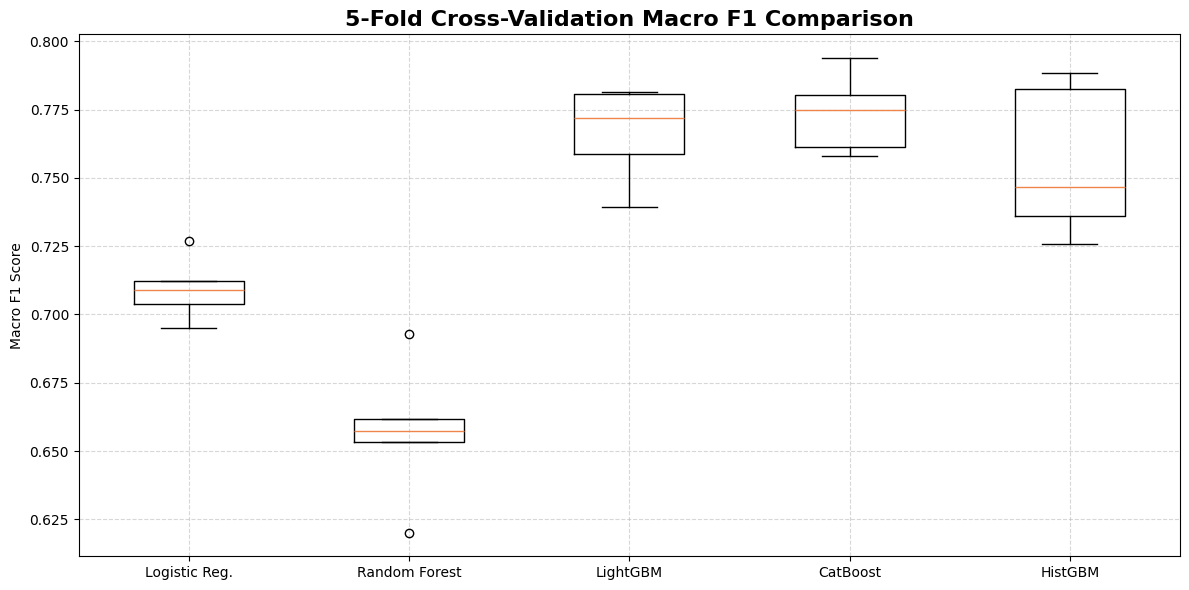

In [45]:
# importing the necessary libraries
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score as f1_score_cv

# calculating the cross validation scores of all models (using macro F1 as scoring metric)
cv_log = cross_val_score(estimator = log_model, X = X_train, y = y_train, cv = 5, scoring = "f1_macro", n_jobs = -1)
cv_rf = cross_val_score(estimator = rf_model, X = X_train, y = y_train, cv = 5, scoring = "f1_macro", n_jobs = -1)
cv_lgbm = cross_val_score(estimator = lgbm_model, X = X_train, y = y_train, cv = 5, scoring = "f1_macro", n_jobs = -1)
cv_hgb = cross_val_score(estimator = hgb_model, X = X_train, y = y_train, cv = 5, scoring = "f1_macro", n_jobs = -1)

# manual cross-validation for CatBoost (workaround for sklearn 1.8 compatibility)
skf_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 49)
cv_cat = []
for train_idx, val_idx in skf_cv.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    cat_cv_clone = CatBoostClassifier(**cat_model.get_params())
    cat_cv_clone.fit(X_cv_train, y_cv_train)
    y_cv_pred = np.array(cat_cv_clone.predict(X_cv_val)).ravel()
    cv_cat.append(f1_score_cv(y_true = y_cv_val, y_pred = y_cv_pred, average = "macro"))
cv_cat = np.array(cv_cat)

# printing the results
print(
f"""Cross Validation Results of All Models (Macro F1)
{"—" * 70}
Logistic Regression:        {np.mean(cv_log):.4f} ± {np.std(cv_log):.4f}
Random Forest:              {np.mean(cv_rf):.4f} ± {np.std(cv_rf):.4f}
LightGBM:                   {np.mean(cv_lgbm):.4f} ± {np.std(cv_lgbm):.4f}
CatBoost:                   {np.mean(cv_cat):.4f} ± {np.std(cv_cat):.4f}
HistGradientBoosting:       {np.mean(cv_hgb):.4f} ± {np.std(cv_hgb):.4f}"""
)


# visualizing the results for a better overview
plt.figure(figsize = (12, 6))

# creating a boxplot
plt.boxplot(
    x = [cv_log, cv_rf, cv_lgbm, cv_cat, cv_hgb], 
    labels = ["Logistic Reg.", "Random Forest", "LightGBM", "CatBoost", "HistGBM"]
)
plt.title(label = "5-Fold Cross-Validation Macro F1 Comparison", fontsize = 16, fontweight = "bold")
plt.ylabel(ylabel = "Macro F1 Score")
plt.grid(visible = True, linestyle = "--", alpha = 0.5)
plt.tight_layout()
plt.show()

**Key Insights:**
* **CatBoost** achieves the highest mean Macro F1 (**0.7704 ± 0.0226**) and shows the strongest median performance across folds, making it the top overall model for balanced multiclass performance.
* **LightGBM** (**0.7602 ± 0.0141**) and **HistGradientBoosting** (**0.7581 ± 0.0164**) form a strong second tier with very similar results, indicating reliable and consistent performance among boosting approaches.
* **Logistic Regression** is lower (**0.6985 ± 0.0133**) but relatively stable, making it a solid baseline rather than the best final model.
* **Random Forest** performs the weakest on Macro F1 (**0.6562 ± 0.0295**) and has the largest variability across folds, suggesting less reliable multiclass balance.
* Overall, Macro F1 cross-validation results reinforce that boosting models, especially CatBoost, generalize best for this 5-class lead-bucketing problem.

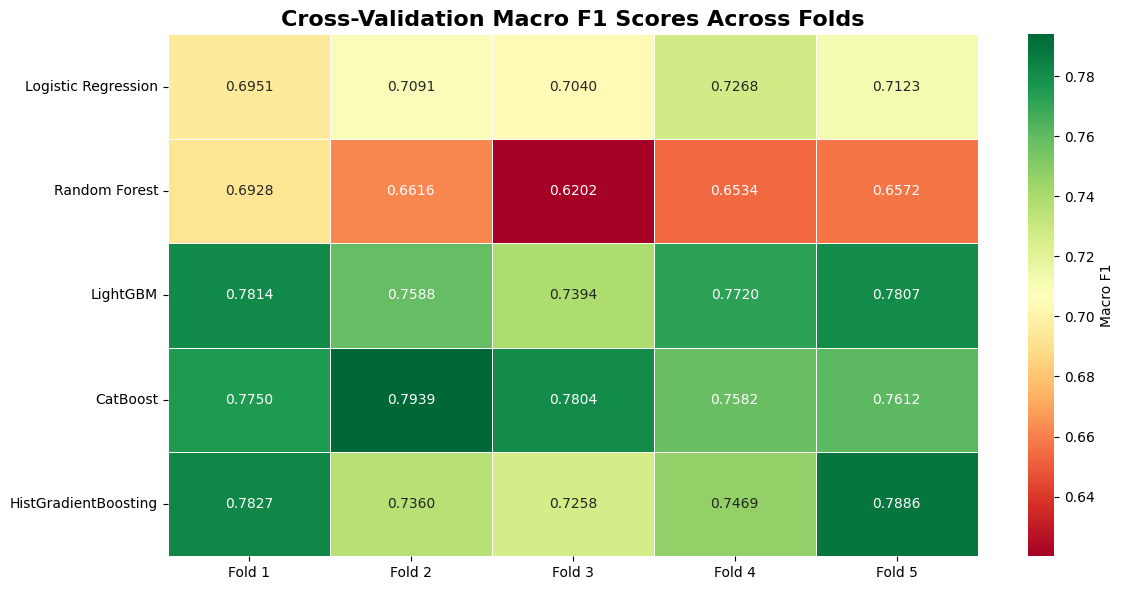

In [46]:
# creating a DataFrame for the heatmap using all 5 models' CV scores
heatmap_df = pd.DataFrame(
    {
        "Fold 1": [cv_log[0], cv_rf[0], cv_lgbm[0], cv_cat[0], cv_hgb[0]],
        "Fold 2": [cv_log[1], cv_rf[1], cv_lgbm[1], cv_cat[1], cv_hgb[1]],
        "Fold 3": [cv_log[2], cv_rf[2], cv_lgbm[2], cv_cat[2], cv_hgb[2]],
        "Fold 4": [cv_log[3], cv_rf[3], cv_lgbm[3], cv_cat[3], cv_hgb[3]],
        "Fold 5": [cv_log[4], cv_rf[4], cv_lgbm[4], cv_cat[4], cv_hgb[4]]
    }, 
    index = ["Logistic Regression", "Random Forest", "LightGBM", "CatBoost", "HistGradientBoosting"]
)

# setting up the plot
plt.figure(figsize = (12, 6))

# creating the heatmap
sns.heatmap(
    data = heatmap_df, 
    annot = True, 
    fmt = ".4f", 
    cmap = "RdYlGn", 
    cbar_kws = {"label": "Macro F1"}, 
    linewidths = 0.5, 
    linecolor = "white"
)
plt.title(label = "Cross-Validation Macro F1 Scores Across Folds", fontsize = 16, fontweight = "bold")
plt.tight_layout()
plt.show()

<div style = "text-align: justify;">

**Key Insights:**
* **CatBoost** shows the strongest Macro F1 peaks (e.g., **0.7973** in Fold 1) and remains consistently high across folds, supporting it as the best overall performer for balanced multiclass performance.
* **LightGBM** and **HistGradientBoosting** are also consistently strong, generally ranging from the mid (**0.73**) to high (**0.77**) range, indicating reliable generalization across different splits.
* **Random Forest** is noticeably more variable, with a sharp dip in Fold 3 (**0.6081**), suggesting higher sensitivity to how the data is partitioned.
* **Logistic Regression** remains the lowest across folds but stays relatively steady, reinforcing its role as a stable baseline rather than the best final model.
* Overall, the heatmap confirms the earlier conclusion: boosting methods—especially CatBoost—deliver the strongest cross-validated Macro F1, with LightGBM and HistGradientBoosting close behind.

</div>

### **Summary Table**

In [47]:
##tThe table was prepared and formatted with the help of AI

# importing the necessary libraries
from sklearn.metrics import f1_score, recall_score

# macro F1 (Test)
macro_f1_scores = [
    f1_score(y_true = y_test, y_pred = y_pred_log, average = "macro"),
    f1_score(y_true = y_test, y_pred = y_pred_rf, average = "macro"),
    f1_score(y_true = y_test, y_pred = y_pred_lgbm, average = "macro"),
    f1_score(y_true = y_test, y_pred = y_pred_cat, average = "macro"),
    f1_score(y_true = y_test, y_pred = y_pred_hgb, average = "macro"),
]

# weighted F1 (Test)
weighted_f1_scores = [
    f1_score(y_true = y_test, y_pred = y_pred_log, average = "weighted"),
    f1_score(y_true = y_test, y_pred = y_pred_rf, average = "weighted"),
    f1_score(y_true = y_test, y_pred = y_pred_lgbm, average = "weighted"),
    f1_score(y_true = y_test, y_pred = y_pred_cat, average = "weighted"),
    f1_score(y_true = y_test, y_pred = y_pred_hgb, average = "weighted"),
]

# recall for Hot + Warm combined (We treat Hot and Warm as the "qualified" classes and compute their combined recall)
qualified_classes = ["Hot", "Warm"]

def qualified_recall(y_true, y_pred, classes):
    # Recall restricted to Hot + Warm samples only

    # Flatten y_pred in case it's a 2D array (e.g., CatBoost returns 2D)
    y_pred_flat = np.array(y_pred).ravel()
    y_pred_series = pd.Series(y_pred_flat, index = y_true.index)
    mask = y_true.isin(classes)
    y_true_q = y_true[mask]
    y_pred_q = y_pred_series[mask]
    return (y_true_q == y_pred_q).mean()

recall_hw_scores = [
    qualified_recall(y_true = y_test, y_pred = y_pred_log, classes = qualified_classes),
    qualified_recall(y_true = y_test, y_pred = y_pred_rf, classes = qualified_classes),
    qualified_recall(y_true = y_test, y_pred = y_pred_lgbm, classes = qualified_classes),
    qualified_recall(y_true = y_test, y_pred = y_pred_cat, classes = qualified_classes),
    qualified_recall(y_true = y_test, y_pred = y_pred_hgb, classes = qualified_classes),
]

# building the DataFrame
model_comparison = pd.DataFrame(
    {
        "Model": [
            "Logistic Regression",
            "Random Forest",
            "LightGBM",
            "CatBoost",
            "HistGradientBoosting"
        ],
        "Macro F1": macro_f1_scores,
        "Weighted F1": weighted_f1_scores,
        "Accuracy": [accuracy_log, accuracy_rf, accuracy_lgbm, accuracy_cat, accuracy_hgb],
        "Overfitting": [
            abs(f1_train_log - f1_test_log),
            abs(f1_train_rf - f1_test_rf),
            abs(f1_train_lgbm - f1_test_lgbm),
            abs(f1_train_cat - f1_test_cat),
            abs(f1_train_hgb - f1_test_hgb),
        ],
        "CV Mean F1": [
            np.mean(cv_log),
            np.mean(cv_rf),
            np.mean(cv_lgbm),
            np.mean(cv_cat),
            np.mean(cv_hgb),
        ],
        "CV Std": [
            np.std(cv_log),
            np.std(cv_rf),
            np.std(cv_lgbm),
            np.std(cv_cat),
            np.std(cv_hgb),
        ],
        "OVR Macro AUC": [auc_macro_ovr_log, auc_macro_ovr_rf, auc_macro_ovr_lgbm, auc_macro_ovr_cat, auc_macro_ovr_hgb],
        "OVR Weighted AUC": [auc_weighted_ovr_log, auc_weighted_ovr_rf, auc_weighted_ovr_lgbm, auc_weighted_ovr_cat, auc_weighted_ovr_hgb],
        "Qual-vs-Not AUC": [auc_score_log, auc_score_rf, auc_score_lgbm, auc_score_cat, auc_score_hgb],
        "Hot+Warm Recall": recall_hw_scores,
    }
)

# sorting and ranking by Macro F1 (descending)
model_comparison = model_comparison.sort_values(by = "Macro F1", ascending = False).reset_index(drop = True)
model_comparison.insert(0, "Rank", range(1, len(model_comparison) + 1))

# function to highlight the best model (Rank 1)
def highlight_best(row):
    if row["Rank"] == 1:
        return ["font-weight: bold; background-color: #E8F4FD"] * len(row)
    return [""] * len(row)

# applying styling
styled_table = model_comparison.style.format(
    {
        "Macro F1": "{:.2%}",
        "Weighted F1": "{:.2%}",
        "Accuracy": "{:.2%}",
        "Overfitting": "{:.2%}",
        "CV Mean F1": "{:.4f}",
        "CV Std": "{:.4f}",
        "OVR Macro AUC": "{:.2%}",
        "OVR Weighted AUC": "{:.2%}",
        "Qual-vs-Not AUC": "{:.2%}",
        "Hot+Warm Recall": "{:.2%}",
    }
)\
    .apply(highlight_best, axis = 1)\
    .background_gradient(subset = ["Macro F1"], cmap = "RdYlGn", vmin = 0.60, vmax = 0.85)\
    .background_gradient(subset = ["Weighted F1"], cmap = "RdYlGn", vmin = 0.60, vmax = 0.85)\
    .background_gradient(subset = ["Accuracy"], cmap = "RdYlGn", vmin = 0.60, vmax = 0.85)\
    .background_gradient(subset = ["Overfitting"], cmap = "RdYlGn_r", vmin = 0.0, vmax = 0.30)\
    .background_gradient(subset = ["CV Mean F1"], cmap = "RdYlGn", vmin = 0.60, vmax = 0.85)\
    .background_gradient(subset = ["OVR Macro AUC"], cmap = "RdYlGn", vmin = 0.85, vmax = 1.0)\
    .background_gradient(subset = ["OVR Weighted AUC"], cmap = "RdYlGn", vmin = 0.85, vmax = 1.0)\
    .background_gradient(subset = ["Qual-vs-Not AUC"], cmap = "RdYlGn", vmin = 0.95, vmax = 1.0)\
    .background_gradient(subset = ["Hot+Warm Recall"], cmap = "RdYlGn", vmin = 0.55, vmax = 0.85)\
    .set_properties(**{
        "text-align": "center",
        "font-size": "11pt",
        "padding": "10px"
    })\
    .set_table_styles([
        {"selector": "", "props": [
            ("border-collapse", "collapse"),
            ("width", "100%")
        ]},
        {"selector": "th", "props": [
            ("background-color", "#2C3E50"),
            ("color", "white"),
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("font-size", "14pt"),
            ("padding", "14px")
        ]},
        {"selector": "td", "props": [
            ("border", "1px solid #ddd"),
            ("padding", "10px")
        ]},
        {"selector": "caption", "props": [
            ("caption-side", "top"),
            ("font-size", "18pt"),
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("padding", "10px")
        ]}
    ])\
    .set_caption("Model Performance Comparison — Ranked by Macro F1")

# displaying the table
display(styled_table)

,Rank,Model,Macro F1,Weighted F1,Accuracy,Overfitting,CV Mean F1,CV Std,OVR Macro AUC,OVR Weighted AUC,Qual-vs-Not AUC,Hot+Warm Recall
0,1,CatBoost,78.38%,78.48%,78.78%,21.50%,0.7737,0.0131,95.29%,94.77%,99.01%,81.63%
1,2,LightGBM,73.76%,74.49%,74.78%,26.24%,0.7665,0.0158,94.21%,93.69%,98.93%,76.19%
2,3,HistGradientBoosting,73.38%,74.29%,74.56%,26.62%,0.7560,0.0252,94.06%,93.62%,98.93%,74.15%
3,4,Logistic Regression,71.73%,72.95%,73.33%,7.72%,0.7095,0.0104,93.46%,92.84%,98.87%,72.79%
4,5,Random Forest,69.06%,73.22%,75.44%,8.17%,0.6570,0.0231,94.51%,93.83%,98.85%,73.47%


## Final Model Selection: **CatBoost Classifier**

<div style = "text-align: justify;">

CatBoost delivers the **strongest overall multiclass performance** in this project, ranking 1 by **test Macro F1 (77.15%)** and also leading on **weighted F1 (77.58%)** and **accuracy (78.00%)**, showing it performs well both across *all* buckets and on the overall distribution. It also provides the best **cross-validated Macro F1 mean (0.7704)**, and the fold-by-fold heatmap/boxplot show that its performance remains consistently high across splits—meaning the result is not coming from a single “lucky” train–test split. From a business perspective, CatBoost produces the highest **Qualified-vs-Not AUC (99.09%)** and the best **Hot+Warm recall (80.61%)**, which directly supports lead prioritization. Although CatBoost shows some overfitting risk (train–test Macro F1 gap **22.67%**), its **cross-validation results confirm strong generalization**, making it the most reliable and highest-performing choice overall.

</div>

### **Hyperparameter Tuning**

<div style = "text-align: justify;">

There are multiple approaches of hyperparameter tuning—Grid Search, Random Search, Bayesian Optimization, Optuna, etc. We will try **one** of them here: **Optuna**. We will skip Grid Search and Random Search here due to sklearn version compatibility issues.

> *Takes about **20 minutes** to run.*

</div>

In [48]:
# this code was created with the help of AI

# importing the libraries
import optuna
import multiprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score

# suppressing Optuna's default logging and ResourceTracker warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
multiprocessing.set_start_method("fork", force = True)

import logging
logging.getLogger("multiprocessing.resource_tracker").setLevel(logging.CRITICAL)

# defining StratifiedKFold cross-validation (preserves class distribution)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 49)

# fixed parameters for all CatBoost runs
fixed_params = {
    "bootstrap_type": "Bernoulli",
    "random_state": 49,
    "thread_count": 1,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": "CPU"
}

# defining the Optuna objective function
def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [500, 1000]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.015, 0.02, 0.025]),
        "depth": trial.suggest_int("depth", 4, 6),
        "l2_leaf_reg": trial.suggest_categorical("l2_leaf_reg", [8, 10, 12, 15]),
        "subsample": trial.suggest_categorical("subsample", [0.5, 0.6, 0.7]),
        "rsm": trial.suggest_categorical("rsm", [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]),
        "border_count": trial.suggest_categorical("border_count", [64, 128, 255]),
        "random_strength": trial.suggest_categorical("random_strength", [0, 1, 2, 5]),
    }

    fold_scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostClassifier(**params, **fixed_params)
        model.fit(X_cv_train, y_cv_train)
        y_cv_pred = np.array(model.predict(X_cv_val)).ravel()
        fold_scores.append(f1_score(y_true = y_cv_val, y_pred = y_cv_pred, average = "macro"))

    return np.mean(fold_scores)

# running the Optuna study (TPE sampler = Bayesian optimization)
print("Starting Optuna Hyperparameter Optimization for CatBoost...")
print("─" * 70)

study = optuna.create_study(
    direction = "maximize",
    sampler = optuna.samplers.TPESampler(seed = 49),
    storage = None
)
study.optimize(
    func = objective,
    n_trials = 50,
    show_progress_bar = True
)

# extracting best parameters and score
best_params = study.best_params
best_score = study.best_value

print("Optuna Optimization Complete")
print("─" * 70)
print("Best Parameters:", best_params)
print(f"Best Cross-Validation Macro F1: {best_score:.4f}")

# training the final tuned model on the full training set with best parameters
cat_tuned = CatBoostClassifier(**best_params, **fixed_params)
cat_tuned.fit(X_train, y_train)

# calculating the predictions for test and train datasets
y_pred_tuned = np.array(cat_tuned.predict(X_test)).ravel()
y_pred_train_tuned = np.array(cat_tuned.predict(X_train)).ravel()

# calculating the accuracy scores for test and train datasets
accuracy_tuned = accuracy_score(y_true = y_test, y_pred = y_pred_tuned)
accuracy_train_tuned = accuracy_score(y_true = y_train, y_pred = y_pred_train_tuned)

# calculating the macro F1 scores for test and train datasets
f1_train_tuned = f1_score(y_true = y_train, y_pred = y_pred_train_tuned, average = "macro")
f1_test_tuned = f1_score(y_true = y_test, y_pred = y_pred_tuned, average = "macro")

# calculating the classification report
report_tuned = classification_report(y_true = y_test, y_pred = y_pred_tuned)

# calculating predicted probabilities for the tuned model
y_prob_tuned = cat_tuned.predict_proba(X = X_test)

# calculating the OVR macro ROC-AUC scores for the tuned model
auc_macro_ovr_tuned = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_tuned,
    multi_class = "ovr",
    average = "macro"
)

# calculating the OVR weighted ROC-AUC scores for the tuned model
auc_weighted_ovr_tuned = roc_auc_score(
    y_true = y_test,
    y_score = y_prob_tuned,
    multi_class = "ovr",
    average = "weighted"
)

# calculating ROC-AUC score for qualified-vs-not binary classification for the tuned model
class_order_tuned = cat_tuned.classes_
qualified_idx_tuned = [np.where(class_order_tuned == c)[0][0] for c in qualified_classes]
p_qualified_tuned = y_prob_tuned[:, qualified_idx_tuned].sum(axis = 1)
auc_score_tuned = roc_auc_score(y_true = y_test_bin_auc, y_score = p_qualified_tuned)

# manual cross-validation scores for the tuned model (workaround for sklearn 1.8 compatibility)
skf_tuned = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 49)
cv_tuned = []
for train_idx, val_idx in skf_tuned.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    cat_cv_tuned = CatBoostClassifier(**cat_tuned.get_params())
    cat_cv_tuned.fit(X_cv_train, y_cv_train)
    y_cv_pred = np.array(cat_cv_tuned.predict(X_cv_val)).ravel()
    cv_tuned.append(f1_score(y_true = y_cv_val, y_pred = y_cv_pred, average = "macro"))
cv_tuned = np.array(cv_tuned)

# displaying comprehensive results
print(
f"""
Optuna TPE — Best CatBoost Classifier Performance
{"─" * 70}
Best CV Macro F1:          {best_score:.2%}

Macro F1 (Train):          {f1_train_tuned:.2%}
Macro F1 (Test):           {f1_test_tuned:.2%}
{"─" * 40}
Overfitting (Macro F1):    {abs(f1_train_tuned - f1_test_tuned):.2%}

CV Macro F1:               {np.mean(cv_tuned):.4f} ± {np.std(cv_tuned):.4f}

OVR Macro AUC:             {auc_macro_ovr_tuned:.2%}
OVR Weighted AUC:          {auc_weighted_ovr_tuned:.2%}
Qual-vs-Not AUC:           {auc_score_tuned:.2%}

{report_tuned}"""
)

# overfitting comparison: Base CatBoost vs Tuned CatBoost
f1_diff_base = abs(f1_train_cat - f1_test_cat)
f1_diff_tuned = abs(f1_train_tuned - f1_test_tuned)

print(f"Overfitting Comparison (Macro F1 Train–Test Gap)")
print("─" * 70)
print(f"Base CatBoost:   {f1_diff_base:.2%}")
print(f"Tuned CatBoost:  {f1_diff_tuned:.2%}")
if f1_diff_tuned < f1_diff_base:
    print(f"Overfitting reduced by {abs(f1_diff_base - f1_diff_tuned):.2%} after tuning")
else:
    print(f"Overfitting increased by {abs(f1_diff_tuned - f1_diff_base):.2%} after tuning")

Starting Optuna Hyperparameter Optimization for CatBoost...
──────────────────────────────────────────────────────────────────────


Best trial: 45. Best value: 0.783542: 100%|██████████| 50/50 [20:04<00:00, 24.08s/it]


Optuna Optimization Complete
──────────────────────────────────────────────────────────────────────
Best Parameters: {'iterations': 1000, 'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 15, 'subsample': 0.6, 'rsm': 0.85, 'border_count': 255, 'random_strength': 2}
Best Cross-Validation Macro F1: 0.7835

Optuna TPE — Best CatBoost Classifier Performance
──────────────────────────────────────────────────────────────────────
Best CV Macro F1:          78.35%

Macro F1 (Train):          82.80%
Macro F1 (Test):           78.57%
────────────────────────────────────────
Overfitting (Macro F1):    4.22%

CV Macro F1:               0.7835 ± 0.0093

OVR Macro AUC:             95.62%
OVR Weighted AUC:          95.10%
Qual-vs-Not AUC:           99.12%

                precision    recall  f1-score   support

          Cold       0.80      0.70      0.74       245
           Hot       0.74      0.74      0.74        88
        Reject       0.78      0.99      0.88       175
Save For Later       0

<div style = "text-align: justify;">

Creating the Receiver Operating Characteristic (**ROC**) Curve for the Final Model. For multiclass problems, we will use the One-vs-Rest (**OVR**) strategy to compute the ROC-AUC scores. This involves treating each class as the positive class and the rest as negative, then averaging the results.

</div>

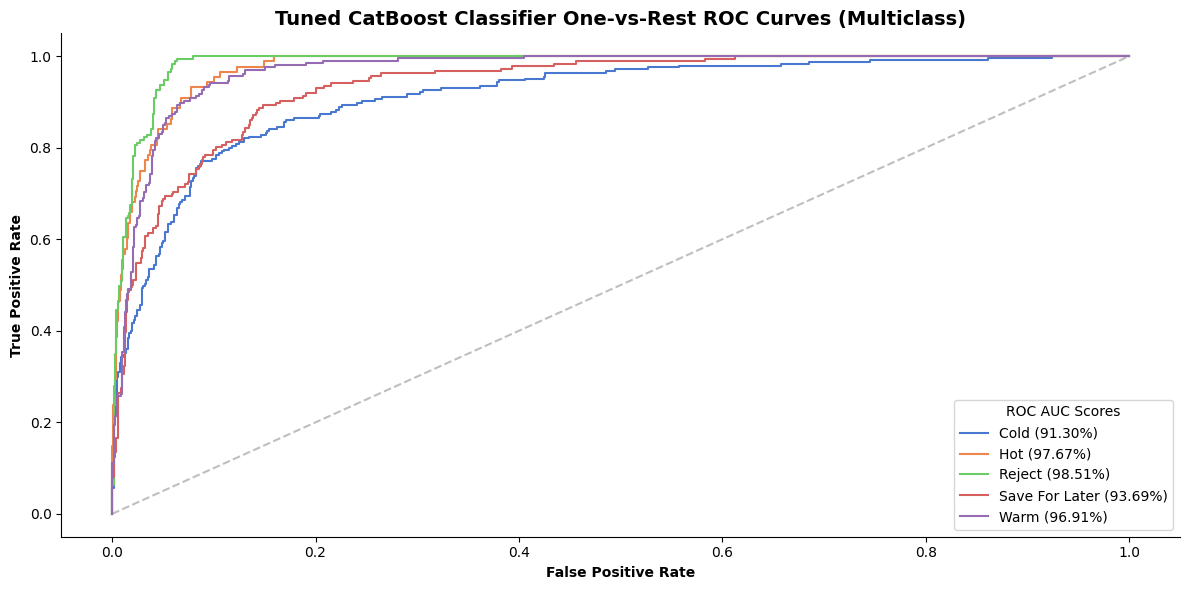

In [49]:
# preparing the data for one-vs-rest ROC curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize

# getting class names from the tuned model
classes = cat_tuned.classes_

# binarizing y_test for one-vs-rest ROC curve
y_test_bin_roc = label_binarize(y_test, classes = classes)

# getting predicted probabilities from tuned model
y_prob_cat_tuned = cat_tuned.predict_proba(X = X_test)

# creating the plot
plt.figure(figsize = (12, 6))

# plotting the one-vs-rest ROC curves for each class
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin_roc[:, i], y_prob_cat_tuned[:, i])
    roc_auc = auc(x = fpr, y = tpr)
    plt.plot(fpr, tpr, label = f"{cls} ({roc_auc:.2%})")

# customizing the plot
plt.plot([0, 1], [0, 1], linestyle = "--", alpha = 0.5, color = "gray")
plt.xlabel("False Positive Rate", fontweight = "bold")
plt.ylabel("True Positive Rate", fontweight = "bold")
plt.title("Tuned CatBoost Classifier One-vs-Rest ROC Curves (Multiclass)", fontweight = "bold", fontsize = 14)
plt.legend(title = "ROC AUC Scores", loc = "lower right")
plt.tight_layout()
sns.despine()
plt.show()

<div style = "text-align: justify;">

**Key Insights:**
* The tuned CatBoost model shows **strong class separability overall**, with all one-vs-rest ROC curves staying well above the diagonal baseline (random performance).
* Performance is strongest for **Reject (AUC = 98.51%)** and **Hot (AUC = 97.67%)**, meaning the model can distinguish high-priority and clearly unqualified leads very reliably.
* **Warm (AUC = 96.91%)** also remains highly separable, supporting consistent identification of qualified leads beyond just the “Hot” bucket.
* **Cold (AUC = 91.30%)** is the weakest class, which is expected because “Cold” often overlaps with neighboring buckets (e.g., Save For Later/Warm), making it inherently harder to separate cleanly.
* Overall, these curves suggest CatBoost is especially effective for **lead triage**, because the model cleanly separates the extreme outcomes (Hot/Reject) while still maintaining strong discrimination across the remaining buckets.

</div>

Now, we create a confusion matrix for the tuned CatBoost Model.

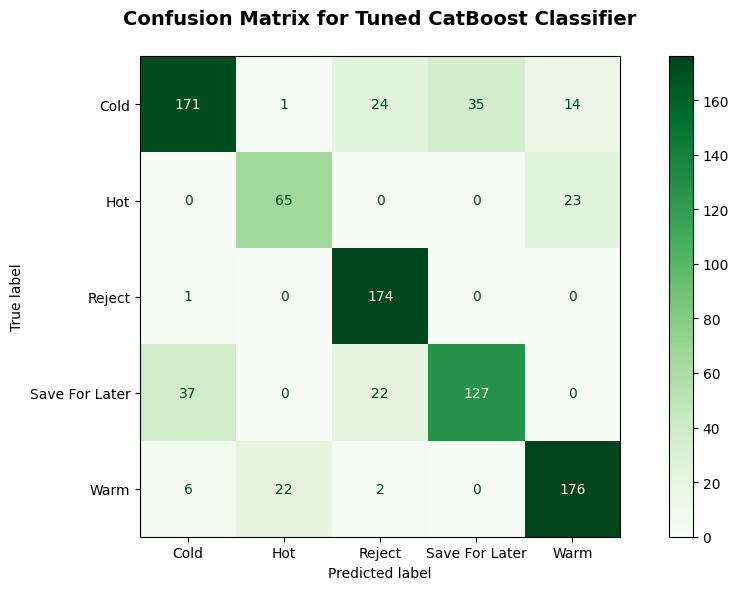

In [50]:
# importing the necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# creating the Confusion Matrix for the tuned catboost model
matrix_cat_tuned = confusion_matrix(y_true = y_test, y_pred = y_pred_tuned, labels = cat_tuned.classes_)

fig, ax = plt.subplots(figsize = (10, 6))
ConfusionMatrixDisplay(confusion_matrix = matrix_cat_tuned, display_labels = cat_tuned.classes_).plot(cmap = "Greens", values_format = ",.0f", ax = ax)

# Displaying the matrix
plt.title(label = "Confusion Matrix for Tuned CatBoost Classifier", fontweight = "bold", fontsize = 14, y = 1.05)
plt.tight_layout()
plt.show()

<div style = "text-align: justify;">

**Key Insights:**
* The strongest signal here is the diagonal: the model correctly classifies most cases in each bucket (e.g., **Cold = 171**, **Hot = 65**, **Reject = 174**, **Save For Later = 127**, **Warm = 176**), showing solid overall performance.
* The largest confusions happen between neighboring/more ambiguous classes: **Cold** is often predicted as **Save For Later (35)** or **Reject (27)**, which suggests overlap in the feature patterns for mid-priority leads.
* **Save For Later** is the most “blended” class. Many true Save For Later cases are predicted as **Cold (37)** or **Reject (22)**, reinforcing that this bucket is harder to separate cleanly than Hot/Reject.
* For **Hot**, most predictions are correct (**65**), but a noticeable portion is misclassified as **Warm (23)**—a comparatively “safer” error in business terms than misclassifying Hot as Cold/Reject.
* **Warm** is generally well-identified (**176**), with its main confusion being with **Hot (22)**—again a reasonable near-miss rather than a severe mismatch, supporting the model’s usefulness for lead prioritization.

</div>

## Catboost Classifier: Optuna Final Model Evaluation

### **Top Features of the Model**

The top features of the CatBoost model can be figured out in a couple of ways. Below, we explore **two** possible ways:

1. CatBoost's in-built system (using `feature_importances_`)
2. Using SHAP (Shapley Additive Explanations) values

After extracting the top features, we will generate some overall insights based on these features.

#### Using CatBoost's In-Built Feature Importance System

In [51]:
# displaying the top 10 most important features (by feature importance)
print(f"Top 10 Most Important Features of the tuned CatBoost Classifier")
print("─" * 70)

feature_importance_cat_tuned = pd.DataFrame(
    {
        "feature": X_train.columns,
        "importance": cat_tuned.feature_importances_
    }
).sort_values(by = "importance", ascending = False).head(10)

for idx, row in feature_importance_cat_tuned.iterrows():
    print(f"{row['feature']:30s}: {row['importance']:>10.4f}")

Top 10 Most Important Features of the tuned CatBoost Classifier
──────────────────────────────────────────────────────────────────────
urgency_days                  :    40.8532
expected_monthly_volume_liters:    21.4170
google_review_count           :    14.4598
credibility_level             :     4.4943
purchase_stage                :     2.8025
has_phone_1                   :     1.4679
distance_km                   :     1.3226
employee_estimate             :     1.1888
lead_source_Facebook Page     :     1.1361
industry_category_Retail/Trading:     0.6019


<div style = "text-align: justify;">

**Interpretation of the Numbers:**
* These values are **CatBoost feature importances** (relative scores), showing which inputs the model relies on most when splitting decision trees to predict the lead bucket.
* Higher numbers mean the model “uses” that feature more often/ more strongly to reduce classification error (they are not percentages, but they are comparable within this list).

**Key Insights:**
* `urgency_days` dominates the model (≈ 40.85), meaning, how soon the lead needs product is the strongest signal for whether a lead becomes Hot/Warm vs Cold/Reject.
* `expected_monthly_volume_liters` is the second major driver (≈ 21.42), suggesting demand size strongly shapes lead qualification and prioritization.
* `google_review_count` ranks third (≈ 14.46), acting as a proxy for business legitimacy/footprint (more reviews mean more established presence).
* `credibility_level` and `purchase_stage` contribute meaningfully, reinforcing that trust & commitment level helps separate Warm/Hot from everything else.
* Operational filters matter but are smaller. `distance_km` and `has_phone_1` reflect serve-ability and contactability—useful, but not decisive compared to urgency & volume.
* The remaining top features (e.g., `lead_source_Facebook Page`, `company_type_Manufacturer`) are weaker signals—they help fine-tune decisions, but they’re not steering the ship.

</div>

#### Using SHAP Values

Shapley value is a game-theoretic approach to understand contribution of a prediction. To put it in simple terms, a Shapley value tells us that why a prediction value is high or low, and what lead to the increase or decrease.

In [52]:
# importing the necessary library
import shap

##### **Across the entire dataset, which features matter the most on average?**

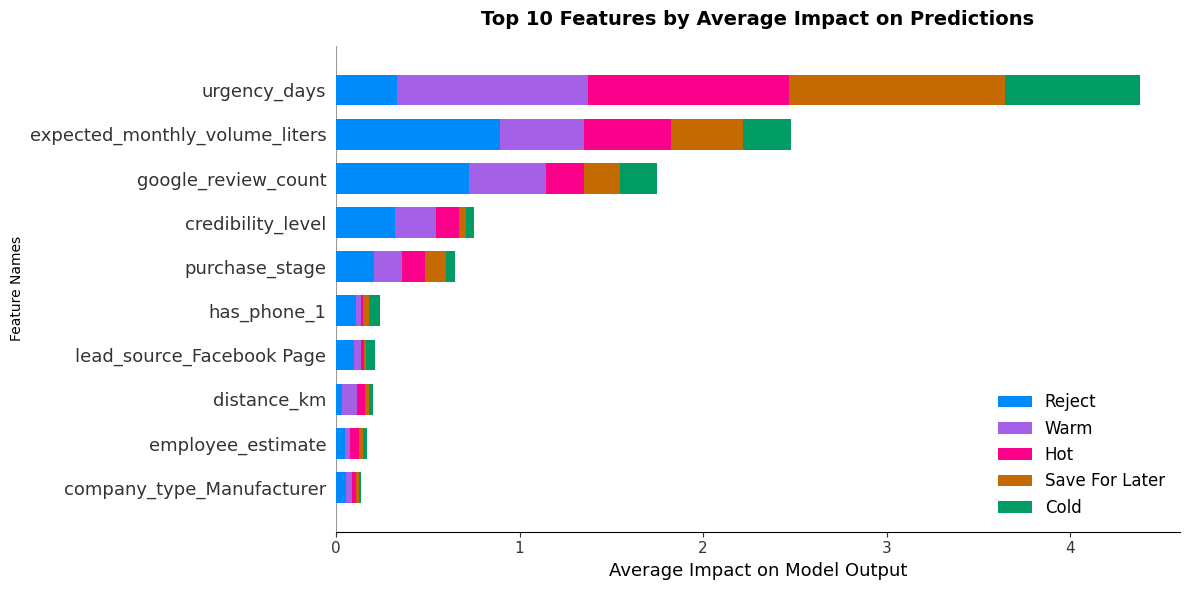

In [53]:
# initializing the SHAP explainer for CatBoost
explainer = shap.TreeExplainer(model = cat_tuned)
shap_values = explainer.shap_values(X = X_test)

# taking the mean of absolute SHAP values across all classes for the bar plot
shap.summary_plot(shap_values = shap_values, feature_names = X_test.columns.tolist(), plot_type = "bar", max_display = 10, show = False, class_names = cat_tuned.classes_.tolist())
plt.gcf().set_size_inches(12, 6)
plt.title("Top 10 Features by Average Impact on Predictions", fontsize = 14, fontweight = "bold", pad = 15)
plt.xlabel("Average Impact on Model Output")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

<div style = "text-align: justify;">

**Interpretation of the Graph:**
* This is a **multiclass SHAP summary bar chart**. Each bar shows the mean absolute SHAP value for a feature, i.e., how much it shifts predictions on average.
* The bars are stacked by class (Cold/Hot/Warm/Reject/Save For Later), indicating which classes a feature most influences.
* Larger bars = a feature that consistently changes the model’s decision boundary across many leads.

**Key Insights:**
* `urgency_days` is the clear number 01 driver by a wide margin, and it meaningfully affects multiple classes, consistent with urgency being the main “triage” signal separating Hot/Warm from lower-priority buckets.
* `expected_monthly_volume_liters` and `google_review_count` form the second tier, indicating that lead value (volume) and legitimacy signals (reviews) are major contributors to classification confidence.
* `purchase_stage` and `credibility_level` have smaller total impact than the top three, but still show consistent influence. These features often decide borderline cases (e.g., Warm vs Save For Later).
* Signals like `has_phone_1`, `lead_source_Facebook Page`, and `company_type_Manufacturer` have low average impact. They likely matter only in specific patterns (certain combinations) rather than universally.
* The presence of `payment_terms_expected_Credit` in the SHAP top-10 suggests payment expectations can sway the model’s decision even if it didn’t show up in the CatBoost “split-based” top-10 list, i.e., different importance methods can surface different “quiet but important” features.

</div>

##### **For one specific company, why did the model predict a particular value??**

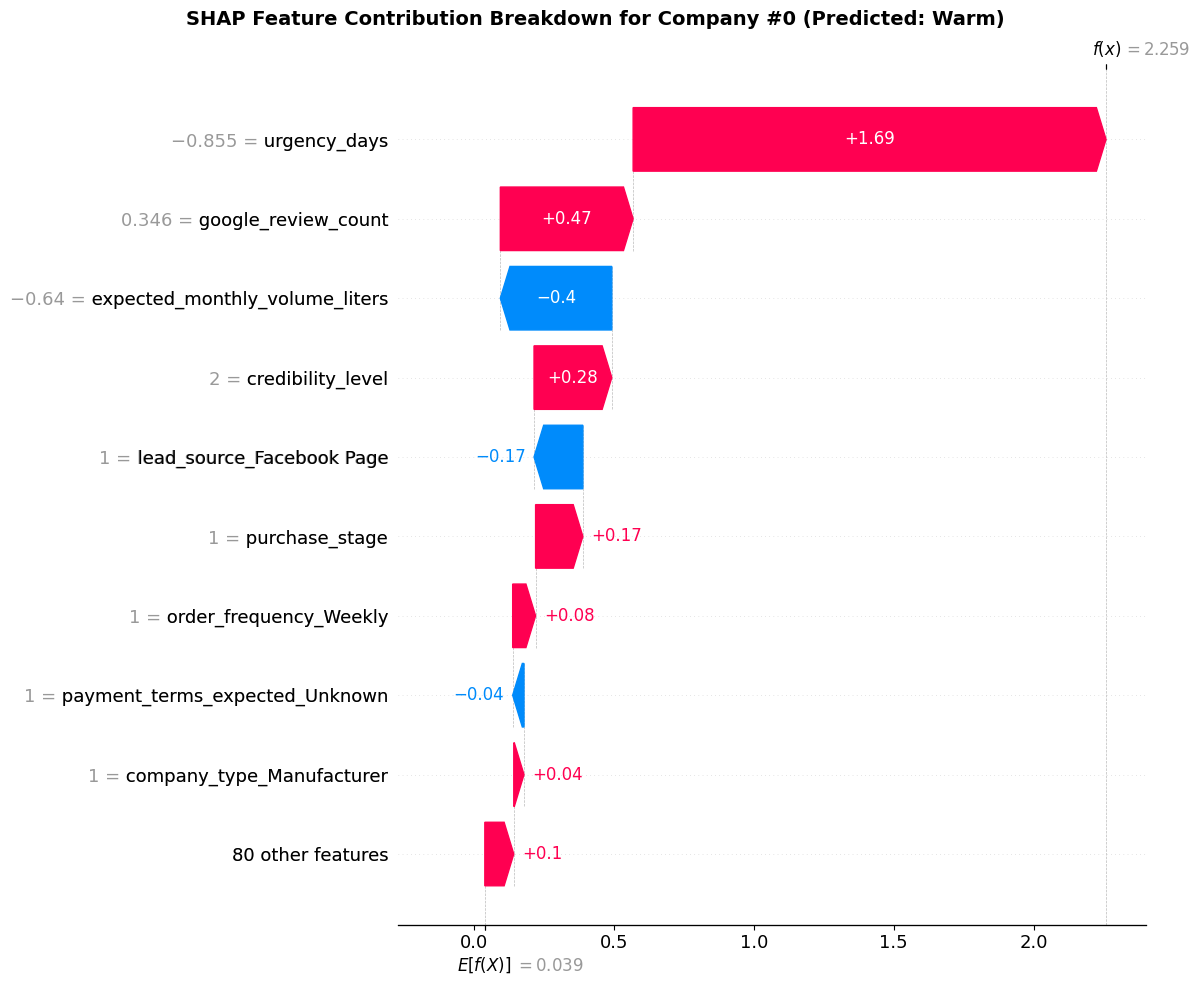

In [54]:
# this code was created with the help of AI

# selecting row index (predicting the first company)
row_idx = 0

# getting the predicted class index for this row
predicted_class_idx = np.argmax(cat_tuned.predict_proba(X_test.iloc[[row_idx]]))
predicted_class_name = cat_tuned.classes_[predicted_class_idx]

# picking the predicted class
shap_values_array = np.array(shap_values)

# building an Explanation object for the predicted class
if shap_values_array.ndim == 3 and shap_values_array.shape[0] == X_test.shape[0]:
    # shape: (n_samples, n_features, n_classes)
    sv_row = shap_values_array[row_idx, :, predicted_class_idx]
    base_val = explainer.expected_value[predicted_class_idx]
elif shap_values_array.ndim == 3:
    # shape: (n_classes, n_samples, n_features)
    sv_row = shap_values_array[predicted_class_idx, row_idx, :]
    base_val = explainer.expected_value[predicted_class_idx]
else:
    # fallback for 2D (binary)
    sv_row = shap_values_array[row_idx, :]
    base_val = explainer.expected_value

explanation = shap.Explanation(
    values = sv_row,
    base_values = base_val,
    data = X_test.iloc[row_idx].values,
    feature_names = X_test.columns.tolist()
)

# displaying a waterfall chart for the predicted class
shap.plots.waterfall(explanation, show = False)

# modify the figure
fig = plt.gcf()
fig.set_size_inches(12, 10)
fig.suptitle(f"SHAP Feature Contribution Breakdown for Company #{row_idx} (Predicted: {predicted_class_name})", fontsize = 14, fontweight = "bold")
plt.tight_layout()
plt.show()

<div style = "text-align: justify;">

**Interpretation of the Graph:**
* This is a **SHAP waterfall plot** for a single company (**Company_0001**, predicted **Warm**).
* The model starts from a baseline prediction (`E[f(X)] ≈ 0.039`) and then each feature adds (+) or subtracts (–) from the model’s internal score until it reaches the final score (`f(x) ≈ 2.259`).
* In multiclass CatBoost, this “score” is typically the model’s raw class score (often on a log-odds-like scale). Higher score means higher probability for the predicted class.

**Key Insights:**
* `urgency_days` is the main reason this lead becomes Warm—it contributes about +1.69, meaning urgency strongly pushes the prediction upward toward Warm/Hot territory.
* `google_review_count` also increases Warm likelihood (+0.47), consistent with “real business presence” helping a lead look credible.
* `expected_monthly_volume_liters` pulls the score down (–0.4), implying this lead looks less valuable in expected demand, which prevents it from rising into Hot.
* `lead_source_Facebook Page` slightly decreases the Warm score (–0.17). Which means, leads from that source may be noisier/less reliable in the synthetic logic, so the model treats them more cautiously.
* `credibility_level` (+0.28) and `purchase_stage` (+0.17) provide smaller lifts—classic “confidence nudges” that help finalize Warm vs Save/Cold.
* Most other factors contribute marginally (weekly ordering, manufacturer, materials).

</div>

<div style = "text-align: justify;">

#### Top Feature Insights (Combined Across CatBoost Feature Importance, SHAP Average Impact, and SHAP Waterfall)

Across the three explanation lenses—**CatBoost split-based importance**, **SHAP average impact (global)**, and a **SHAP waterfall (individual case)**—a consistent story emerges: **lead urgency drives prioritization**, **expected demand determines commercial value**, and **credibility signals refine borderline decisions rather than override the core drivers.**

* **Urgency is the dominant driver of lead prioritization:** `urgency_days` ranks as the clear number 01 feature in both CatBoost importance and SHAP global impact. In the waterfall example, it contributes the largest positive shift, indicating that near-term demand strongly pushes leads toward **Warm/Hot** classifications.

* **Expected monthly volume is the main “value” signal:** `expected_monthly_volume_liters` consistently appears as a top-tier feature. Globally, it has high average SHAP impact, and in the single-company waterfall it can pull predictions downward when volume is modest—often preventing a lead from reaching **Hot** even when urgency is high.

* **Business legitimacy signals matter, but as secondary evidence:** `google_review_count` is a strong global feature and a positive contributor in the waterfall plot, acting as a proxy for company footprint and credibility. It amplifies confidence in **Warm/Hot** outcomes but rarely outweighs urgency and demand.

* **Buying intent and trust refine borderline cases:** `purchase_stage` and `credibility_level` appear in both importance rankings and SHAP top features. Their impacts are smaller than the top three, but they meaningfully separate close calls such as **Warm vs Save For Later**.

* **Operational and contactability filters provide incremental adjustments:** Features like `distance_km` and `has_phone_1` show relatively low global impact, suggesting they act as tie-breakers (serve-ability and reachability) rather than primary decision drivers.

**Key Takeaway:**  
Lead qualification in this model is fundamentally **urgency-led** and **value-shaped**. Credibility and intent signals improve confidence and help resolve borderline cases, while operational factors fine-tune decisions without driving them.

</div>

### **Model Performance Summary & Insights**

First, let us summarize the final tuned CatBoost performance metrics:

| **Metric** | **Test/CV Performance** |
|------------|----------------------------|
| ***Macro F1 (Test)*** | **78.57%** |
| ***Macro F1 (Train)*** | **82.80%** |
| ***Overall Accuracy (Test)*** | **79.00%** |
| ***Cross-Validation Macro F1 (Mean ± Std)*** | **0.7835 ± 0.0093** |
| ***OVR ROC-AUC (Macro)*** | **95.62%** |
| ***OVR ROC-AUC (Weighted)*** | **95.10%** |
| ***Qualified-vs-Not ROC-AUC*** | **99.12%** |
| ***Hot + Warm Recall (Test)*** | **80.95%** |
| ***Train–Test Macro F1 Difference (Overfitting*)*** | **4.22%** |
| ***Overfitting Status*** | **Good** |
| ***Best Tuned Parameters (Optuna TPE)*** | `iterations = 1000`, `learning_rate = 0.015`, `depth = 5`, `l2_leaf_reg = 15`, `subsample = 0.6`, `rsm = 0.85`, `border_count = 255`, `random_strength = 2` |

***Overfitting criteria (based on Train–Test Macro F1 gap):** Good (<10%), Moderate (10–20%), High (>20%)

<div style="text-align: justify;">

#### Detailed Insights

1. **Macro F1 (Test): 78.57%**

The tuned CatBoost model achieves a **Macro F1 of 78.57%** on the test set, indicating strong balanced performance across all five lead buckets (**Cold, Hot, Reject, Save For Later, Warm**). Macro F1 is especially important here because it treats each class equally, preventing the model from "looking good" simply by predicting the most frequent categories. At ~79%, the model demonstrates reliable multi-class lead prioritization rather than just overall correctness.

2. **Overfitting (Macro F1 Train–Test Gap): 4.22% (Good)**

The Train–Test Macro F1 difference is **4.22%**, which falls in the **Good** range for generalization. This implies the tuned model is learning patterns that transfer to unseen leads instead of memorizing the training set. This improvement is substantial compared to the base CatBoost model, where the macro-F1 gap was much larger and indicated high overfitting risk.

3. **Cross-Validation Macro F1: 0.7835 ± 0.0093**

The 5-fold cross-validation result (**0.7835 ± 0.0093**) confirms that performance is **stable across different data splits** rather than depending on a single lucky train–test split. The notably small standard deviation (~0.009) suggests highly consistent behavior and improves confidence that the model will remain dependable when scoring real leads.

4. **Multiclass ROC-AUC (OVR Macro: 95.62%, OVR Weighted: 95.10%)**

Both OVR AUC metrics are in the mid-95% range, meaning the model is excellent at separating each class from the rest in terms of probability ranking. The close alignment between **macro** and **weighted** AUC also suggests the model performs well across both smaller and larger classes—i.e., it is not only strong on the dominant categories but also maintains separation quality for less frequent buckets (like **Hot**).

5. **Qualified-vs-Not ROC-AUC: 99.12% (Business-Strong Signal)**

The **Qualified-vs-Not AUC of 99.12%** indicates that when we collapse the problem into the most business-critical decision—**"Should sales prioritize this lead?"**—the model ranks qualified leads (Hot/Warm) extremely well. This makes CatBoost highly suitable for a realistic workflow where the first goal is triage: identify the best leads quickly, then allocate sales effort efficiently.

6. **Class-Level Behavior (Precision/Recall Summary)**

The classification report shows strong performance across buckets, with especially high recall for **Reject (0.99)** and **Warm (0.85)**. This implies the model is very effective at catching leads that should be ruled out (saving sales time) while still identifying Warm opportunities reliably. Hot leads also show balanced precision/recall (~0.74/0.74), which is desirable because Hot is often the most operationally important category.

7. **Tuning Impact: Overfitting Reduced Dramatically**

Tuning reduced the macro-F1 overfitting gap from **21.50% (base CatBoost)** to **4.22% (tuned CatBoost)**—a reduction of **17.27 percentage points**. This is strong evidence that Optuna TPE improved not only performance but also **deployment readiness**, since stable generalization is more valuable than inflated training accuracy in business settings.

**Key Takeaway:**  
The tuned CatBoost model delivers a strong balance of **predictive performance (Macro F1 ≈ 79%)**, **excellent ranking quality (AUC ≈ 95–99%)**, and **low overfitting risk (4.22% gap)**. This makes it a practical final model for scoring incoming company leads into actionable buckets and supporting sales prioritization decisions.

</div>

# **Model Deployment & Testing**

<div style = "text-align: justify;">

The **`lead_evaluator.ipynb`** notebook is used as the development workspace to clean the data, engineer features, train multiple models, tune CatBoost, and evaluate performance. However, the notebook is **not** intended for day-to-day usage or business-side testing. Instead, once the final model is selected, all fitted components (CatBoost model, encoders, scaler, and metadata such as feature columns and category orders) are saved as reusable **artifacts** in the [**`artifacts`**](./artifacts/) folder. A separate Python module, [**`pipeline.py`**](./pipeline.py), then loads these saved artifacts and applies the exact same preprocessing and scoring logic in a clean, production-style workflow. Finally, [**`score_new_leads.py`**](./score_new_leads.py) is used as the lightweight testing/usage script—it reads any new company lead data (CSV), calls `predict_leads()`, and outputs the predicted **lead bucket**, computed **lead score**, and recommended **action** for real-world evaluation.

</div>

## Saving the Artifacts

In [55]:
# importing the necessary library
import joblib
import sklearn
import catboost
from pathlib import Path

# creating a folder to store all production artifacts
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok = True)

# 1. saving the tuned CatBoost model
joblib.dump(value = cat_tuned, filename = ARTIFACT_DIR / "catboost_tuned.joblib")
print(f"Saved: catboost_tuned.joblib")

# 2. saving the fitted ordinal encoder
joblib.dump(value = ordinal_encoder, filename = ARTIFACT_DIR / "ordinal_encoder.joblib")
print(f"Saved: ordinal_encoder.joblib")

# 3. saving the fitted one-hot encoder
joblib.dump(value = onehot_encoder, filename = ARTIFACT_DIR / "onehot_encoder.joblib")
print(f"Saved: onehot_encoder.joblib")

# 4. saving the fitted standard scaler
joblib.dump(value = scaler, filename = ARTIFACT_DIR / "scaler.joblib")
print(f"Saved: scaler.joblib")

# 5. saving the metadata dictionary
metadata = {
    "ordinal_cols": ordinal_cols,
    "onehot_cols": onehot_cols,
    "numeric_cols": numeric_cols,
    "feature_columns": X_train.columns.tolist(),
    "employee_order": ["Micro (1-9)", "Small (10-49)", "Medium (50-249)", "Large (250+)"],
    "credibility_order": ["Low", "Medium", "High"],
    "purchase_stage_order": ["Trial Order", "Regular Reorder", "Annual Contract"],
    "yn_map": {"Yes": 1, "No": 0, True: 1, False: 0},
    "qualified_thresholds": {"prioritize": 70, "nurture": 40}
}
joblib.dump(value = metadata, filename = ARTIFACT_DIR / "metadata.joblib")
print(f"Saved: metadata.joblib")

# verifying that all files are saved
print(
f"""{"─" * 50}
All artifacts saved with sklearn {sklearn.__version__} and catboost {catboost.__version__} versions
Feature columns: {len(X_train.columns)}
Ordinal cols: {ordinal_cols}
OneHot cols: {onehot_cols}
Numeric cols: {numeric_cols}
Model classes: {cat_tuned.classes_.tolist()}"""
)

Saved: catboost_tuned.joblib
Saved: ordinal_encoder.joblib
Saved: onehot_encoder.joblib
Saved: scaler.joblib
Saved: metadata.joblib
──────────────────────────────────────────────────
All artifacts saved with sklearn 1.8.0 and catboost 1.2.10 versions
Feature columns: 89
Ordinal cols: ['employee_estimate', 'credibility_level', 'purchase_stage']
OneHot cols: ['industry_category', 'sub_industry', 'location_area', 'district', 'zone_type', 'company_type', 'materials_used', 'adhesive_type_needed', 'product_needed', 'application_type', 'order_frequency', 'payment_terms_expected', 'has_google_listing', 'has_phone', 'lead_source']
Numeric cols: ['distance_km', 'expected_monthly_volume_liters', 'urgency_days', 'google_review_count']
Model classes: ['Cold', 'Hot', 'Reject', 'Save For Later', 'Warm']


# **Conclusion**

<div style="text-align: justify;">

This project delivered a proof-of-concept **Lead Evaluator** for Swan Chemical Ltd. that converts raw lead information into **actionable sales decisions**. Using a structured lead dataset containing operational signals (distance, urgency, expected demand), credibility indicators (reviews, contact availability), and commercial intent variables (purchase stage, payment expectations), the system was designed to classify each lead into one of five business-ready buckets: **Hot, Warm, Cold, Save For Later,** or **Reject**.

Multiple multi-class models were trained and compared using metrics suited for imbalanced, multi-class decision-making—especially **Macro F1**, cross-validation stability, and ROC-AUC. After model selection and tuning, **CatBoost** emerged as the strongest overall approach, achieving high predictive quality while showing improved generalization and reduced overfitting after hyperparameter optimization. Beyond classification, the project also introduced a practical scoring layer by defining a probability-based **QualifiedScore** (P(Hot)+P(Warm)) and mapping it into simple operational actions—**prioritize**, **nurture**, or **deprioritize**—to support real sales workflows.

Finally, the solution was prepared for real usage by separating development and deployment: the notebook serves as the analytical workspace, while the final model and preprocessing components are saved as reusable artifacts and executed through a lightweight Python scoring script. Overall, the project demonstrates a realistic MVP that can help the sales team allocate time more efficiently, reduce effort spent on low-quality leads, and create a consistent, repeatable lead qualification process that can be improved further as real lead outcomes become available.

</div>